In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
#from keras.layers import Embedding
import proplot as pplt
from kmodes.kprototypes import KPrototypes
import plotly.express as px

import warnings
warnings.filterwarnings('ignore') 

In [44]:
df =  pd.read_csv("Data_test.csv",sep=";")

In [45]:
df.head()

,ID,Customer ID,City Code,Region Code,Accomodation Ownership,Insurance Type,Age,Married,Plan Code,Policy Duration,Policy Type,Policy Category,Premium Amount,Claim
0,32003,81040.0,C3,3029,Rented,Individual,65.0,No,NaN,NaN,NaN,22,40171.0,1
1,32285,88349.0,C4,2583,Rented,Individual,19.0,No,X2,NaN,NaN,12,13308.0,0
2,2530,80799.0,C6,4479,Rented,Individual,24.0,No,X2,NaN,NaN,2,41781.0,0
3,43305,72065.0,C11,267,Owned,Individual,66.0,No,X3,14+,2.0,22,15383.0,0
4,15714,84093.0,C2,4534,Owned,Individual,52.0,No,X1,14+,3.0,3,43924.0,0


In [46]:
df.columns = ['ID', 'Cust_ID', 'City_Code', 'Reg_Code', 'Accom_Own', 'Ins_Type', 'Age_Entry', 'Marital_Stat', 'Plan_Code', 'Pol_Dur',
                'Pol_Type', 'Pol_Cat', 'Prem_Amnt', 'Claim']

In [47]:
df.describe()

,ID,Cust_ID,Reg_Code,Age_Entry,Pol_Type,Pol_Cat,Prem_Amnt,Claim
count,50882.000000,50869.000000,50882.000000,50874.000000,30631.000000,50882.000000,50871.000000,50882.000000
mean,25441.500000,79993.806542,1732.788707,42.753568,2.439228,15.115188,30209.212459,0.239947
std,14688.512535,5766.505723,1424.081652,17.836079,1.025923,6.340663,15257.341750,0.427055
min,1.000000,70000.000000,1.000000,-20.000000,1.000000,1.000000,-15002.000000,0.000000
25%,12721.250000,74991.000000,523.000000,27.000000,1.000000,12.000000,19947.500000,0.000000
50%,25441.500000,80002.000000,1391.000000,40.000000,3.000000,17.000000,29874.000000,0.000000
75%,38161.750000,84986.000000,2667.000000,57.000000,3.000000,20.000000,40011.500000,0.000000
max,50882.000000,90000.000000,6194.000000,1000.000000,4.000000,22.000000,1000000.000000,1.000000


In [48]:
df['Prem_Amnt'].max()

1000000.0

In [49]:
df["Prem_Amnt"].quantile([0.001, 0.05, 0.25, 0.5, 0.75, 0.95,0.999])

0.001     3174.06
0.050    11950.00
0.250    19947.50
0.500    29874.00
0.750    40011.50
0.950    48007.00
0.999    50000.00
Name: Prem_Amnt, dtype: float64

In [56]:
df['Prem_Amnt'].fillna(median_prem_amn, inplace=True)

In [6]:
import statistics

modus_plan_code = statistics.mode(df["Plan_Code"])
modus_pol_dur = statistics.mode(df["Pol_Dur"])
modus_pol_type = statistics.mode(df["Pol_Type"])
median_age = df["Age_Entry"].median()
median_prem_amn = df["Prem_Amnt"].median()

In [7]:
df['Plan_Code'].fillna(modus_plan_code, inplace=True)
df['Pol_Dur'].fillna("14+", inplace=True)
df['Pol_Type'].fillna(modus_pol_type, inplace=True)
df['Age_Entry'].fillna(median_age, inplace=True)
df['Prem_Amnt'].fillna(median_prem_amn, inplace=True)

In [8]:
df["Age_Entry"] = np.where(df["Age_Entry"] >75, median_age,df['Age_Entry'])
df["Age_Entry"] = np.where(df["Age_Entry"] <0, median_age,df['Age_Entry'])

In [9]:
df["Prem_Amnt"].quantile([0.001, 0.05, 0.25, 0.5, 0.75, 0.95,0.999])

0.001     3174.478
0.050    11950.050
0.250    19948.250
0.500    29874.000
0.750    40009.000
0.950    48006.950
0.999    50000.000
Name: Prem_Amnt, dtype: float64

In [61]:
df["Prem_Amnt"].max()

1000000.0

In [63]:
binnedprem = pd.cut(df['Prem_Amnt'], 10)
binnedprem.value_counts()

(-16017.002, 86498.2]    50832
(86498.2, 187998.4]         13
(390998.8, 492499.0]        13
(289498.6, 390998.8]        12
(187998.4, 289498.6]        11
(898499.8, 1000000.0]        1
(492499.0, 593999.2]         0
(593999.2, 695499.4]         0
(695499.4, 796999.6]         0
(796999.6, 898499.8]         0
Name: Prem_Amnt, dtype: int64

In [64]:
df["Prem_Amnt"].quantile(0)

-15002.0

In [65]:
max_prem_treshold = df["Prem_Amnt"].quantile(0.999)
min_prem_treshold = df["Prem_Amnt"].quantile(0.001)

In [66]:
max_prem_treshold, min_prem_treshold

(50000.0, 3174.478)

In [67]:
df = df[(df.Prem_Amnt>min_prem_treshold)&(df.Prem_Amnt<max_prem_treshold)]

In [68]:
binnedprem = pd.cut(df['Prem_Amnt'], 10)
binnedprem.value_counts()

(21906.2, 26588.0]    6005
(17224.4, 21906.2]    5981
(35951.6, 40633.4]    5955
(26588.0, 31269.8]    5954
(40633.4, 45315.2]    5942
(45315.2, 49997.0]    5925
(12542.6, 17224.4]    5915
(31269.8, 35951.6]    5825
(7860.8, 12542.6]     3250
(3132.182, 7860.8]      27
Name: Prem_Amnt, dtype: int64

In [69]:
df["Prem_Amnt"].min(),df["Prem_Amnt"].max()

(3179.0, 49997.0)

Text(0.5, 0, 'Prem Amount (per 100,000)')

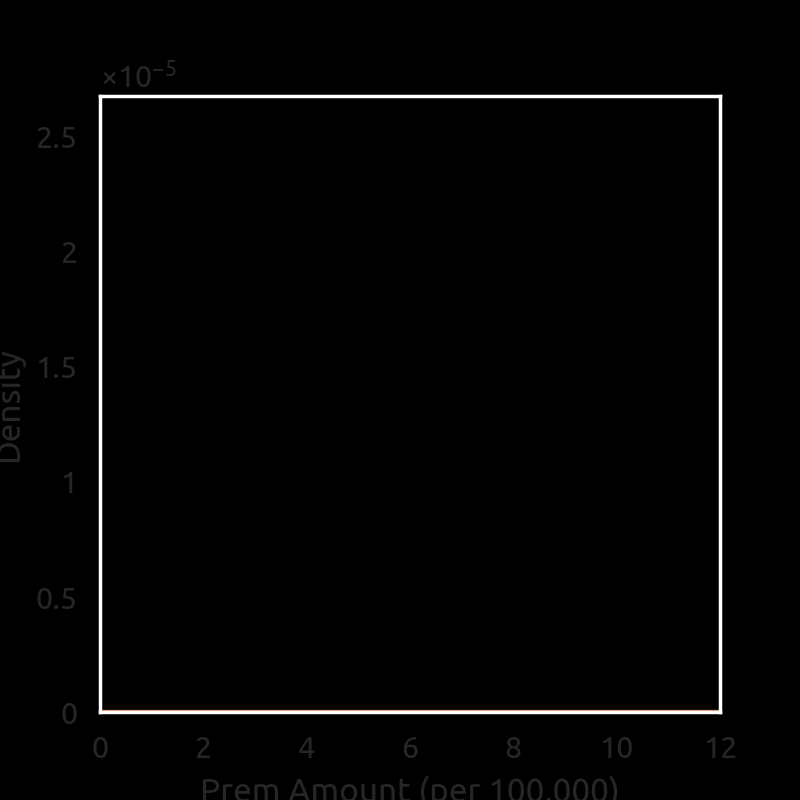

In [71]:
ax = df['Prem_Amnt'].plot.hist(density=True, xlim=[0,12], bins=range(1,12))
df['Prem_Amnt'].plot.density(ax=ax)
ax.set_xlabel('Prem Amount (per 100,000)')

In [13]:
df["Ins_Type"] = np.where(df["Ins_Type"] == "Individua","Individual",df['Ins_Type'])
df["Ins_Type"] = np.where(df["Ins_Type"] == "Sendiri","Individual",df['Ins_Type'])
df["Ins_Type"] = np.where(df["Ins_Type"] == "joint","Joint",df['Ins_Type'])
df["Ins_Type"] = np.where(df["Ins_Type"] == "Gabungan","Joint",df['Ins_Type'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50779 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            50779 non-null  int64  
 1   Cust_ID       50766 non-null  float64
 2   City_Code     50779 non-null  object 
 3   Reg_Code      50779 non-null  int64  
 4   Accom_Own     50779 non-null  object 
 5   Ins_Type      50779 non-null  object 
 6   Age_Entry     50779 non-null  float64
 7   Marital_Stat  50779 non-null  object 
 8   Plan_Code     50779 non-null  object 
 9   Pol_Dur       50779 non-null  object 
 10  Pol_Type      50779 non-null  float64
 11  Pol_Cat       50779 non-null  int64  
 12  Prem_Amnt     50779 non-null  float64
 13  Claim         50779 non-null  int64  
dtypes: float64(4), int64(4), object(6)
memory usage: 5.8+ MB


In [15]:
df

,ID,Cust_ID,City_Code,Reg_Code,Accom_Own,Ins_Type,Age_Entry,Marital_Stat,Plan_Code,Pol_Dur,Pol_Type,Pol_Cat,Prem_Amnt,Claim
0,32003,81040.0,C3,3029,Rented,Individual,65.0,No,X1,14+,3.0,22,40171.0,1
1,32285,88349.0,C4,2583,Rented,Individual,19.0,No,X2,14+,3.0,12,13308.0,0
2,2530,80799.0,C6,4479,Rented,Individual,24.0,No,X2,14+,3.0,2,41781.0,0
3,43305,72065.0,C11,267,Owned,Individual,66.0,No,X3,14+,2.0,22,15383.0,0
4,15714,84093.0,C2,4534,Owned,Individual,52.0,No,X1,14+,3.0,3,43924.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,42509,83742.0,C1,1801,Owned,Individual,75.0,No,X1,14+,3.0,18,22505.0,0
50878,30647,85810.0,C4,1746,Owned,Individual,31.0,No,X5,2.0,2.0,7,24212.0,0
50879,13645,82369.0,C17,328,Rented,Joint,55.0,Yes,X1,10.0,3.0,21,17270.0,0
50880,13989,77662.0,C3,1592,Owned,Individual,57.0,No,X5,14+,3.0,18,32658.0,0


In [16]:
df1 = df.drop(columns=['ID','Cust_ID','Reg_Code','Ins_Type','Pol_Cat','Plan_Code','Pol_Type'])

In [17]:
df1

,City_Code,Accom_Own,Age_Entry,Marital_Stat,Pol_Dur,Prem_Amnt,Claim
0,C3,Rented,65.0,No,14+,40171.0,1
1,C4,Rented,19.0,No,14+,13308.0,0
2,C6,Rented,24.0,No,14+,41781.0,0
3,C11,Owned,66.0,No,14+,15383.0,0
4,C2,Owned,52.0,No,14+,43924.0,0
...,...,...,...,...,...,...,...
50877,C1,Owned,75.0,No,14+,22505.0,0
50878,C4,Owned,31.0,No,2.0,24212.0,0
50879,C17,Rented,55.0,Yes,10.0,17270.0,0
50880,C3,Owned,57.0,No,14+,32658.0,0


### LABEL ENCODER

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [19]:
cate = []
for i in df1.columns:
    if (df1[i].dtypes == "object"):
        cate.append(i)

print(cate)

['City_Code', 'Accom_Own', 'Marital_Stat', 'Pol_Dur']


In [20]:
lbl_encode = LabelEncoder()
for i in cate:
    df1[i]=df1[[i]].apply(lbl_encode.fit_transform)

In [21]:
df1.head()

,City_Code,Accom_Own,Age_Entry,Marital_Stat,Pol_Dur,Prem_Amnt,Claim
0,22,1,65.0,0,5,40171.0,1
1,30,1,19.0,0,5,13308.0,0
2,32,1,24.0,0,5,41781.0,0
3,2,0,66.0,0,5,15383.0,0
4,11,0,52.0,0,5,43924.0,0


In [22]:
df1.describe()

,City_Code,Accom_Own,Age_Entry,Marital_Stat,Pol_Dur,Prem_Amnt,Claim
count,50779.000000,50779.000000,50779.000000,50779.000000,50779.000000,50779.000000,50779.000000
mean,14.975561,0.450501,42.738297,0.165521,6.122157,29964.596428,0.240139
std,12.146373,0.497549,17.320665,0.371654,3.273212,11564.730562,0.427172
min,0.000000,0.000000,1.000000,0.000000,0.000000,3179.000000,0.000000
25%,4.000000,0.000000,27.000000,0.000000,5.000000,19968.500000,0.000000
50%,11.000000,0.000000,40.000000,0.000000,5.000000,29874.000000,0.000000
75%,30.000000,1.000000,57.000000,0.000000,8.000000,39993.000000,0.000000
max,35.000000,1.000000,75.000000,1.000000,14.000000,49997.000000,1.000000


### STANDARDIZATION

In [23]:
scaled_features = StandardScaler().fit_transform(df1.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df1.index, columns=df1.columns)

In [24]:
scaled_features_df.head()

,City_Code,Accom_Own,Age_Entry,Marital_Stat,Pol_Dur,Prem_Amnt,Claim
0,0.578321,1.104423,1.285281,-0.445368,-0.342834,0.882554,1.778837
1,1.236961,1.104423,-1.370532,-0.445368,-0.342834,-1.440307,-0.562165
2,1.401621,1.104423,-1.081857,-0.445368,-0.342834,1.021772,-0.562165
3,-1.068277,-0.905450,1.343016,-0.445368,-0.342834,-1.260880,-0.562165
4,-0.327308,-0.905450,0.534725,-0.445368,-0.342834,1.207079,-0.562165


### MODELING CLUSTERING

#### Elbow method

In [25]:
from sklearn.cluster import KMeans

  0%|          | 0/9 [00:00<?, ?it/s]

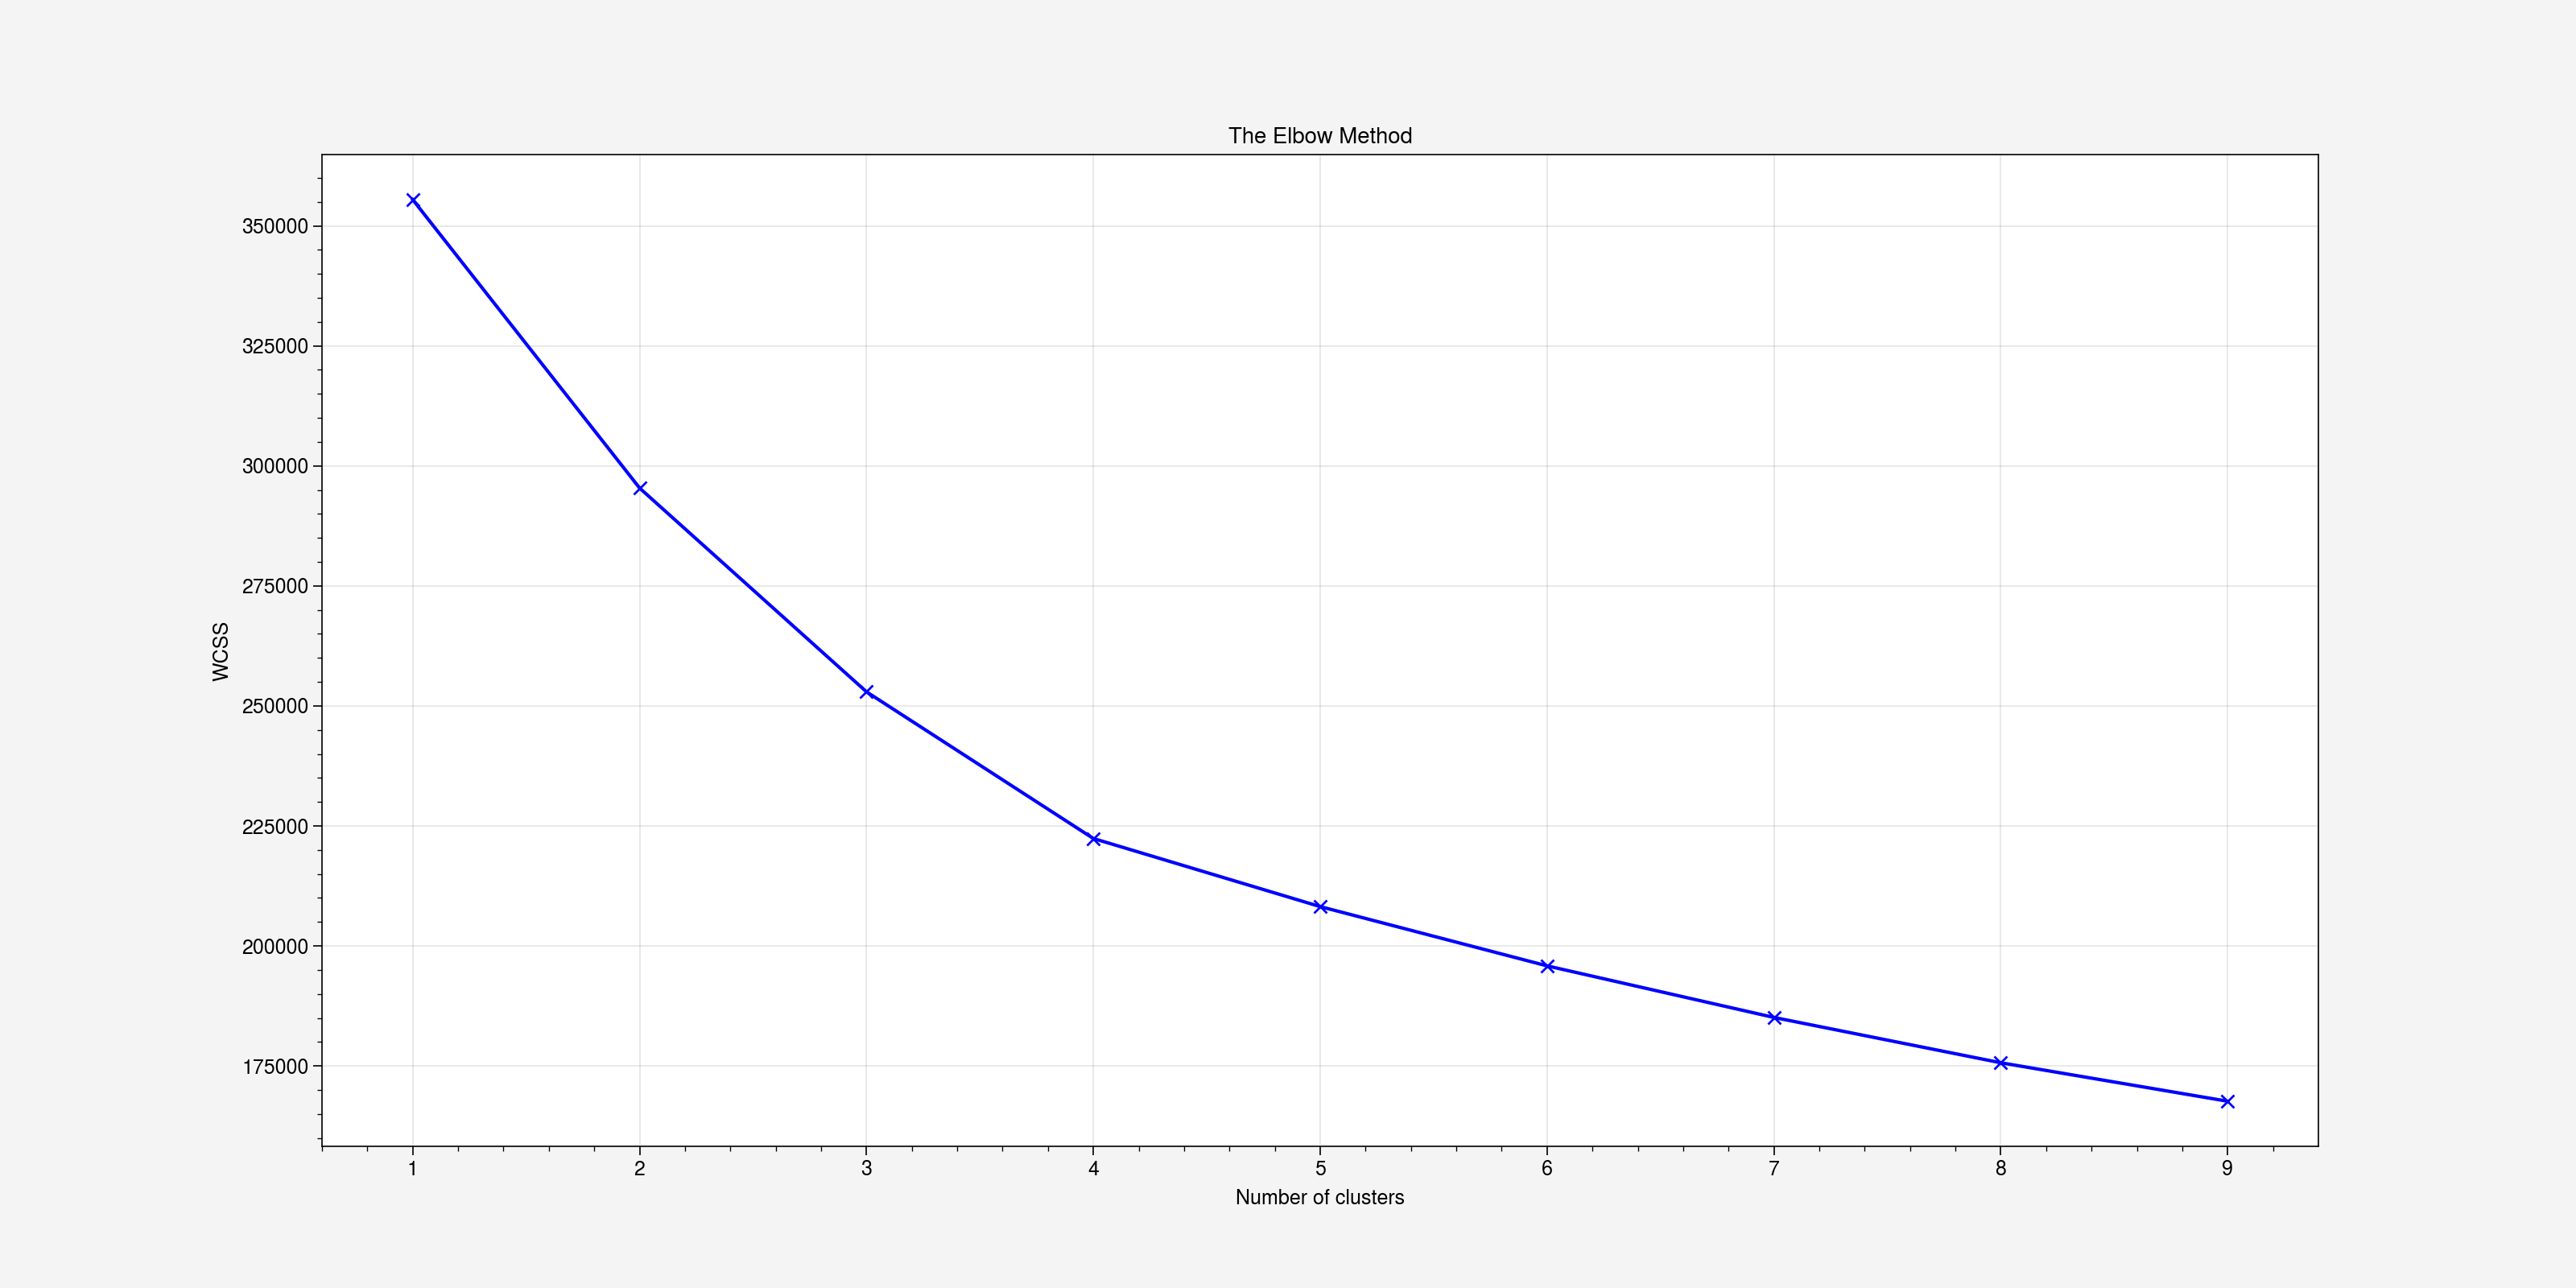

In [26]:
from tqdm.auto import tqdm
wcss=[]
for i in tqdm(range (1,10)):
 kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
 kmeans.fit(scaled_features_df)
 wcss.append(kmeans.inertia_)
plt.figure(figsize=(16,8))
plt.plot(range(1,10),wcss, 'bx-')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Silhouette Score

In [27]:
from sklearn.metrics import silhouette_score 

  0%|          | 0/8 [00:00<?, ?it/s]

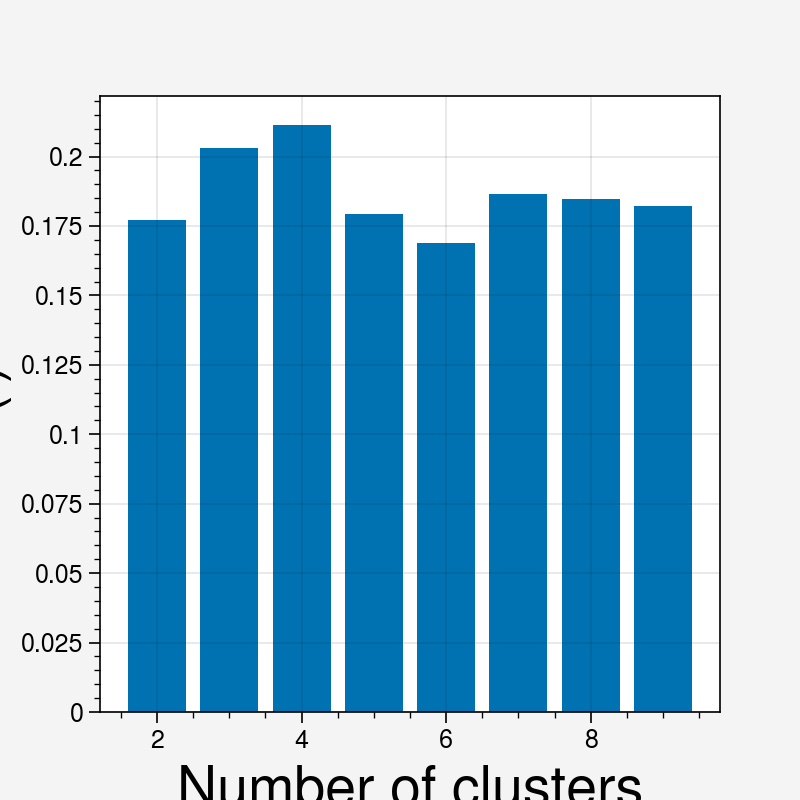

In [28]:
silhouette_scores = []
for i in tqdm(range(2,10)):
    m1=KMeans(n_clusters=i, random_state=42)
    c = m1.fit_predict(scaled_features_df)
    silhouette_scores.append(silhouette_score(scaled_features_df, m1.fit_predict(scaled_features_df))) 
plt.bar(range(2,10), silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

In [29]:
silhouette_scores

[0.17698145292895773,
 0.20294891735477408,
 0.211230203452688,
 0.17939152134213132,
 0.16887831648597484,
 0.18655856715531793,
 0.18460161757828397,
 0.18232337315065836]

In [30]:
# Getting the maximum value of silhouette score and adding 2 in index because index starts from 2.

sc=max(silhouette_scores)
number_of_clusters=silhouette_scores.index(sc)+2
print("Number of Cluster Required is : ", number_of_clusters)

Number of Cluster Required is :  4


### Model Building

In [31]:
# Training a predicting using K-Means Algorithm.

kmeans=KMeans(n_clusters=number_of_clusters, random_state=42).fit(scaled_features_df)
pred=kmeans.predict(scaled_features_df)


# Appending those cluster value into main dataframe (without standard-scalar)

df1['cluster'] = pred + 1

In [32]:
pred

array([3, 1, 1, ..., 0, 2, 0])

In [33]:
scaled_features_df.head()

,City_Code,Accom_Own,Age_Entry,Marital_Stat,Pol_Dur,Prem_Amnt,Claim
0,0.578321,1.104423,1.285281,-0.445368,-0.342834,0.882554,1.778837
1,1.236961,1.104423,-1.370532,-0.445368,-0.342834,-1.440307,-0.562165
2,1.401621,1.104423,-1.081857,-0.445368,-0.342834,1.021772,-0.562165
3,-1.068277,-0.905450,1.343016,-0.445368,-0.342834,-1.260880,-0.562165
4,-0.327308,-0.905450,0.534725,-0.445368,-0.342834,1.207079,-0.562165


In [34]:
df1.head()

,City_Code,Accom_Own,Age_Entry,Marital_Stat,Pol_Dur,Prem_Amnt,Claim,cluster
0,22,1,65.0,0,5,40171.0,1,4
1,30,1,19.0,0,5,13308.0,0,2
2,32,1,24.0,0,5,41781.0,0,2
3,2,0,66.0,0,5,15383.0,0,3
4,11,0,52.0,0,5,43924.0,0,3


In [35]:
for col in df1.columns:
    print(col, '\t: ', len(df1[col].unique()), 'label')

City_Code 	:  36 label
Accom_Own 	:  2 label
Age_Entry 	:  62 label
Marital_Stat 	:  2 label
Pol_Dur 	:  15 label
Prem_Amnt 	:  28716 label
Claim 	:  2 label
cluster 	:  4 label


In [36]:
df.City_Code.value_counts().sort_values(ascending=False).head(36), df1.City_Code.value_counts().sort_values(ascending=False).head(36)

(C1     8950
 C2     7736
 C3     4881
 C4     3664
 C9     2179
 C6     1944
 C7     1906
 C8     1803
 C10    1609
 C5     1362
 C15    1185
 C17    1159
 C11    1147
 C16    1132
 C13    1002
 C20     923
 C19     895
 C12     865
 C18     794
 C14     743
 C21     678
 C23     585
 C24     551
 C22     516
 C26     499
 C29     387
 C25     366
 C27     294
 C33     285
 C28     284
 C32     160
 C34     130
 C30      58
 C35      56
 C36      36
 C31      15
 Name: City_Code, dtype: int64,
 0     8950
 11    7736
 22    4881
 30    3664
 35    2179
 32    1944
 33    1906
 34    1803
 1     1609
 31    1362
 6     1185
 8     1159
 2     1147
 7     1132
 4     1002
 12     923
 10     895
 3      865
 9      794
 5      743
 13     678
 15     585
 16     551
 14     516
 18     499
 21     387
 17     366
 19     294
 26     285
 20     284
 25     160
 27     130
 23      58
 28      56
 29      36
 24      15
 Name: City_Code, dtype: int64)

### CLUSTERING

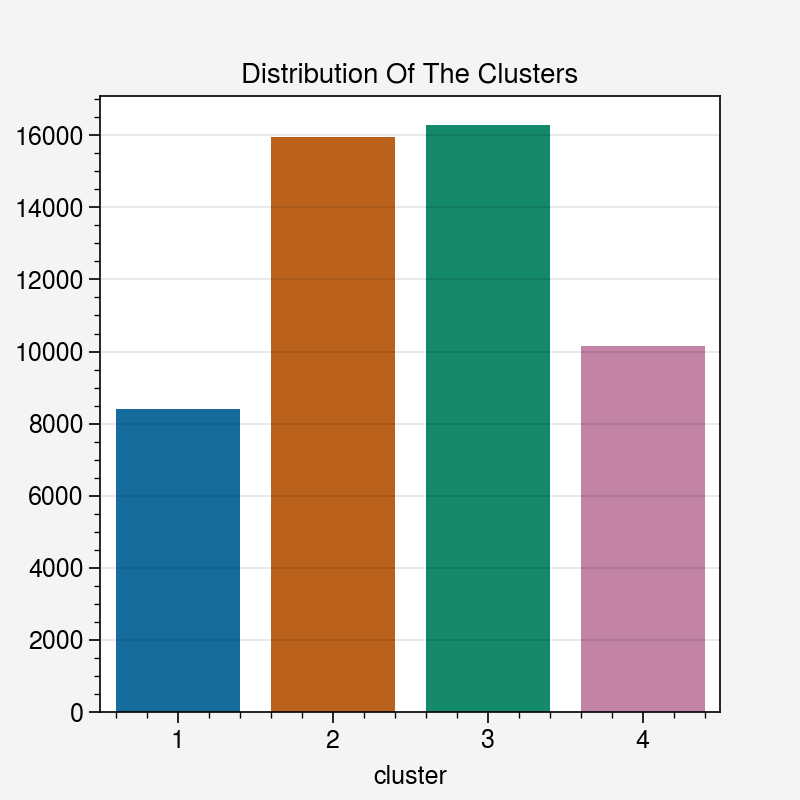

In [37]:
pl = sns.countplot(x=df1["cluster"])
pl.set_title("Distribution Of The Clusters")
plt.show()

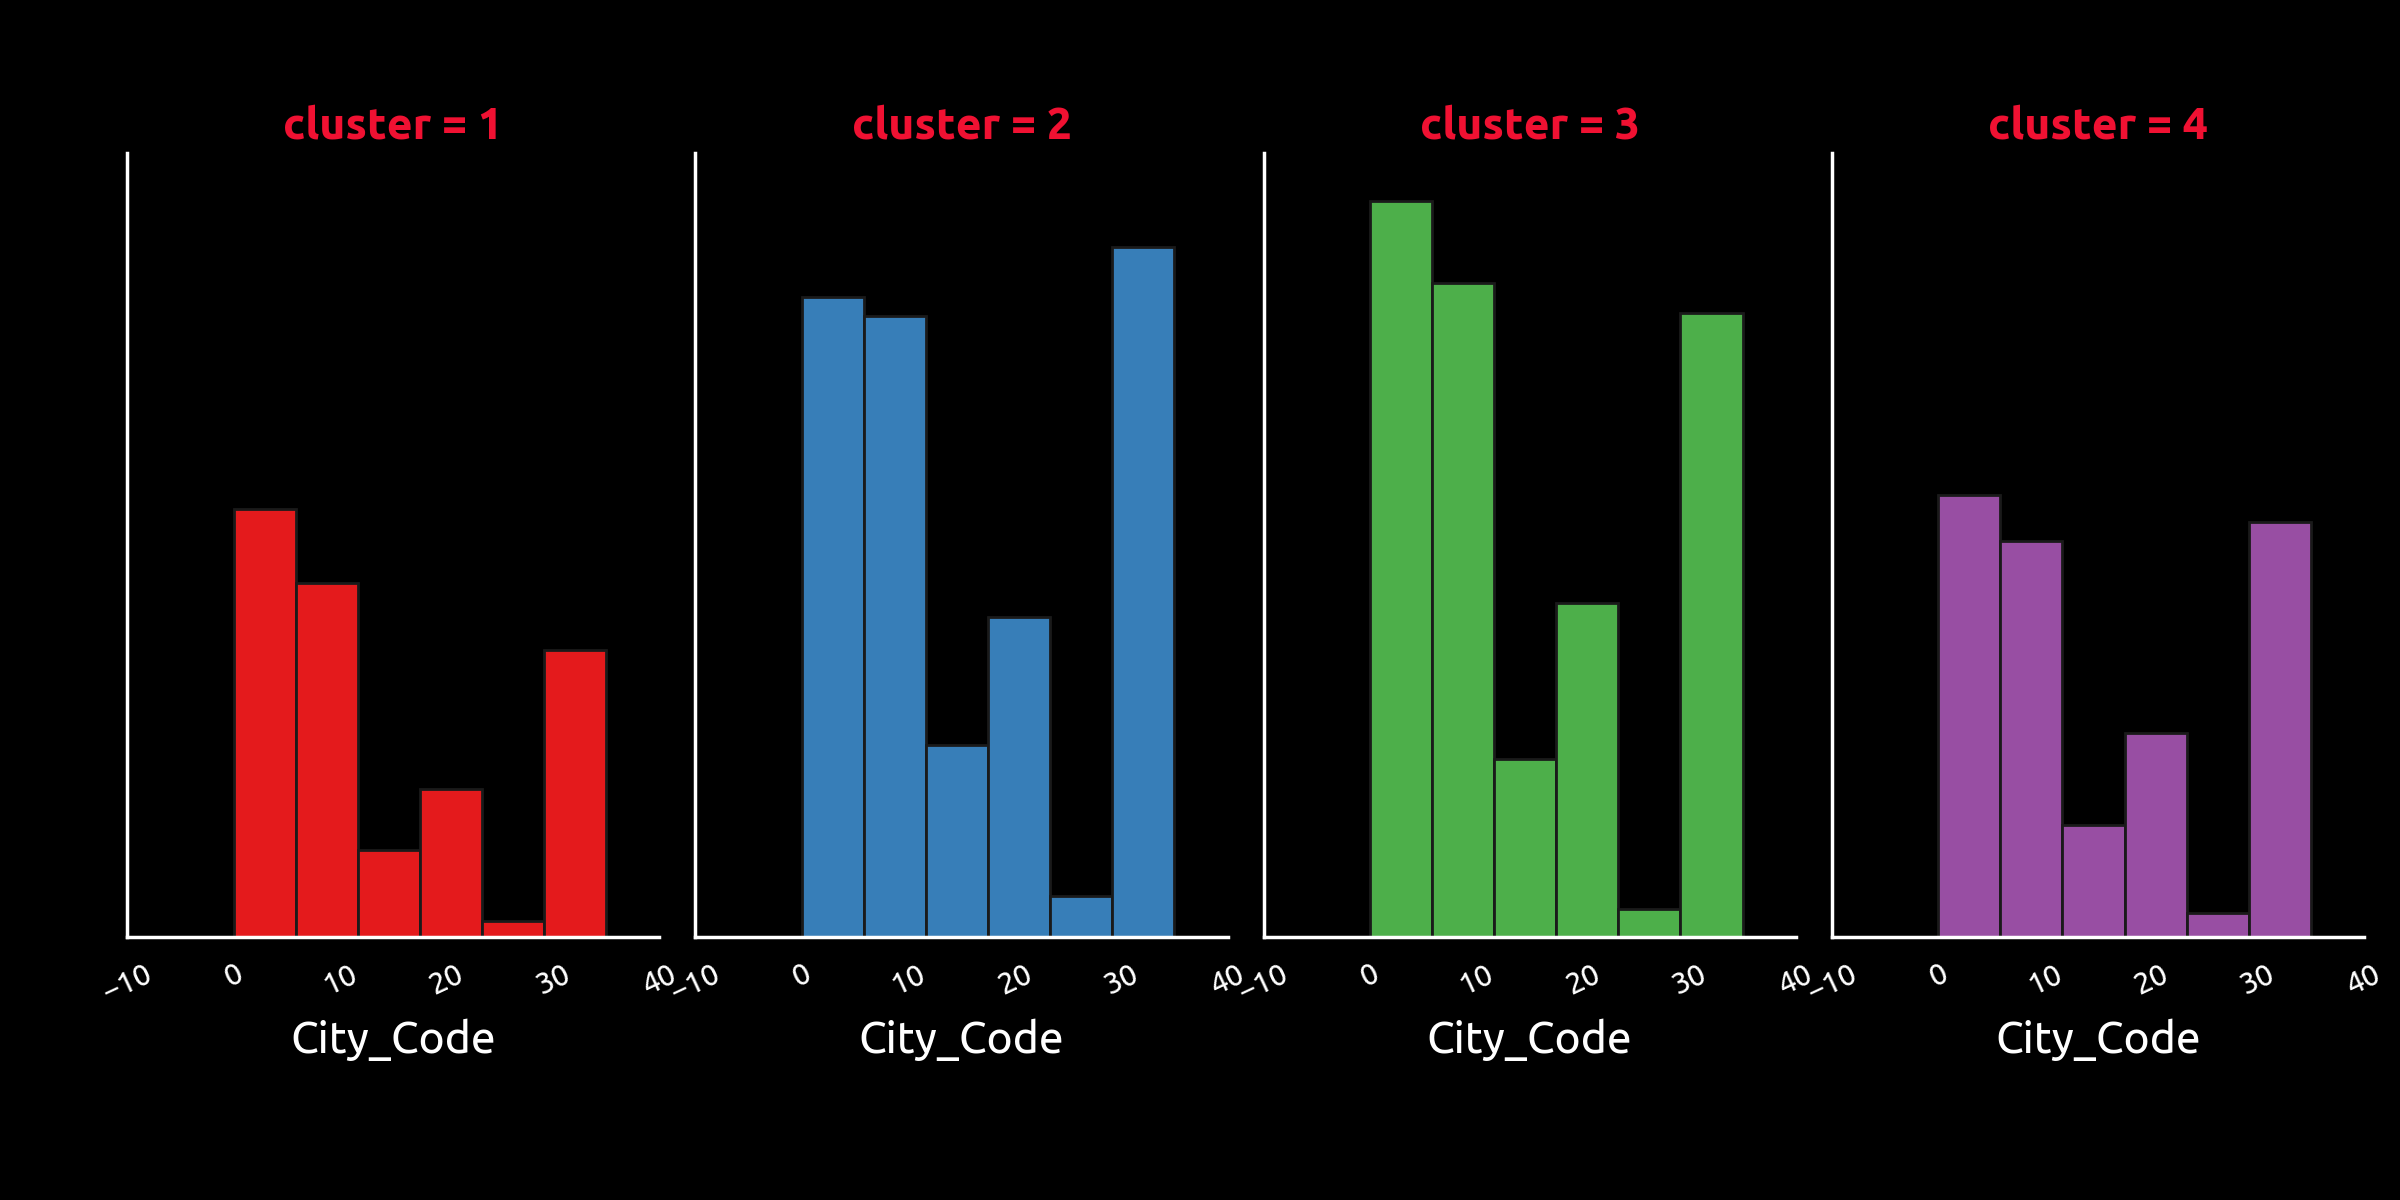

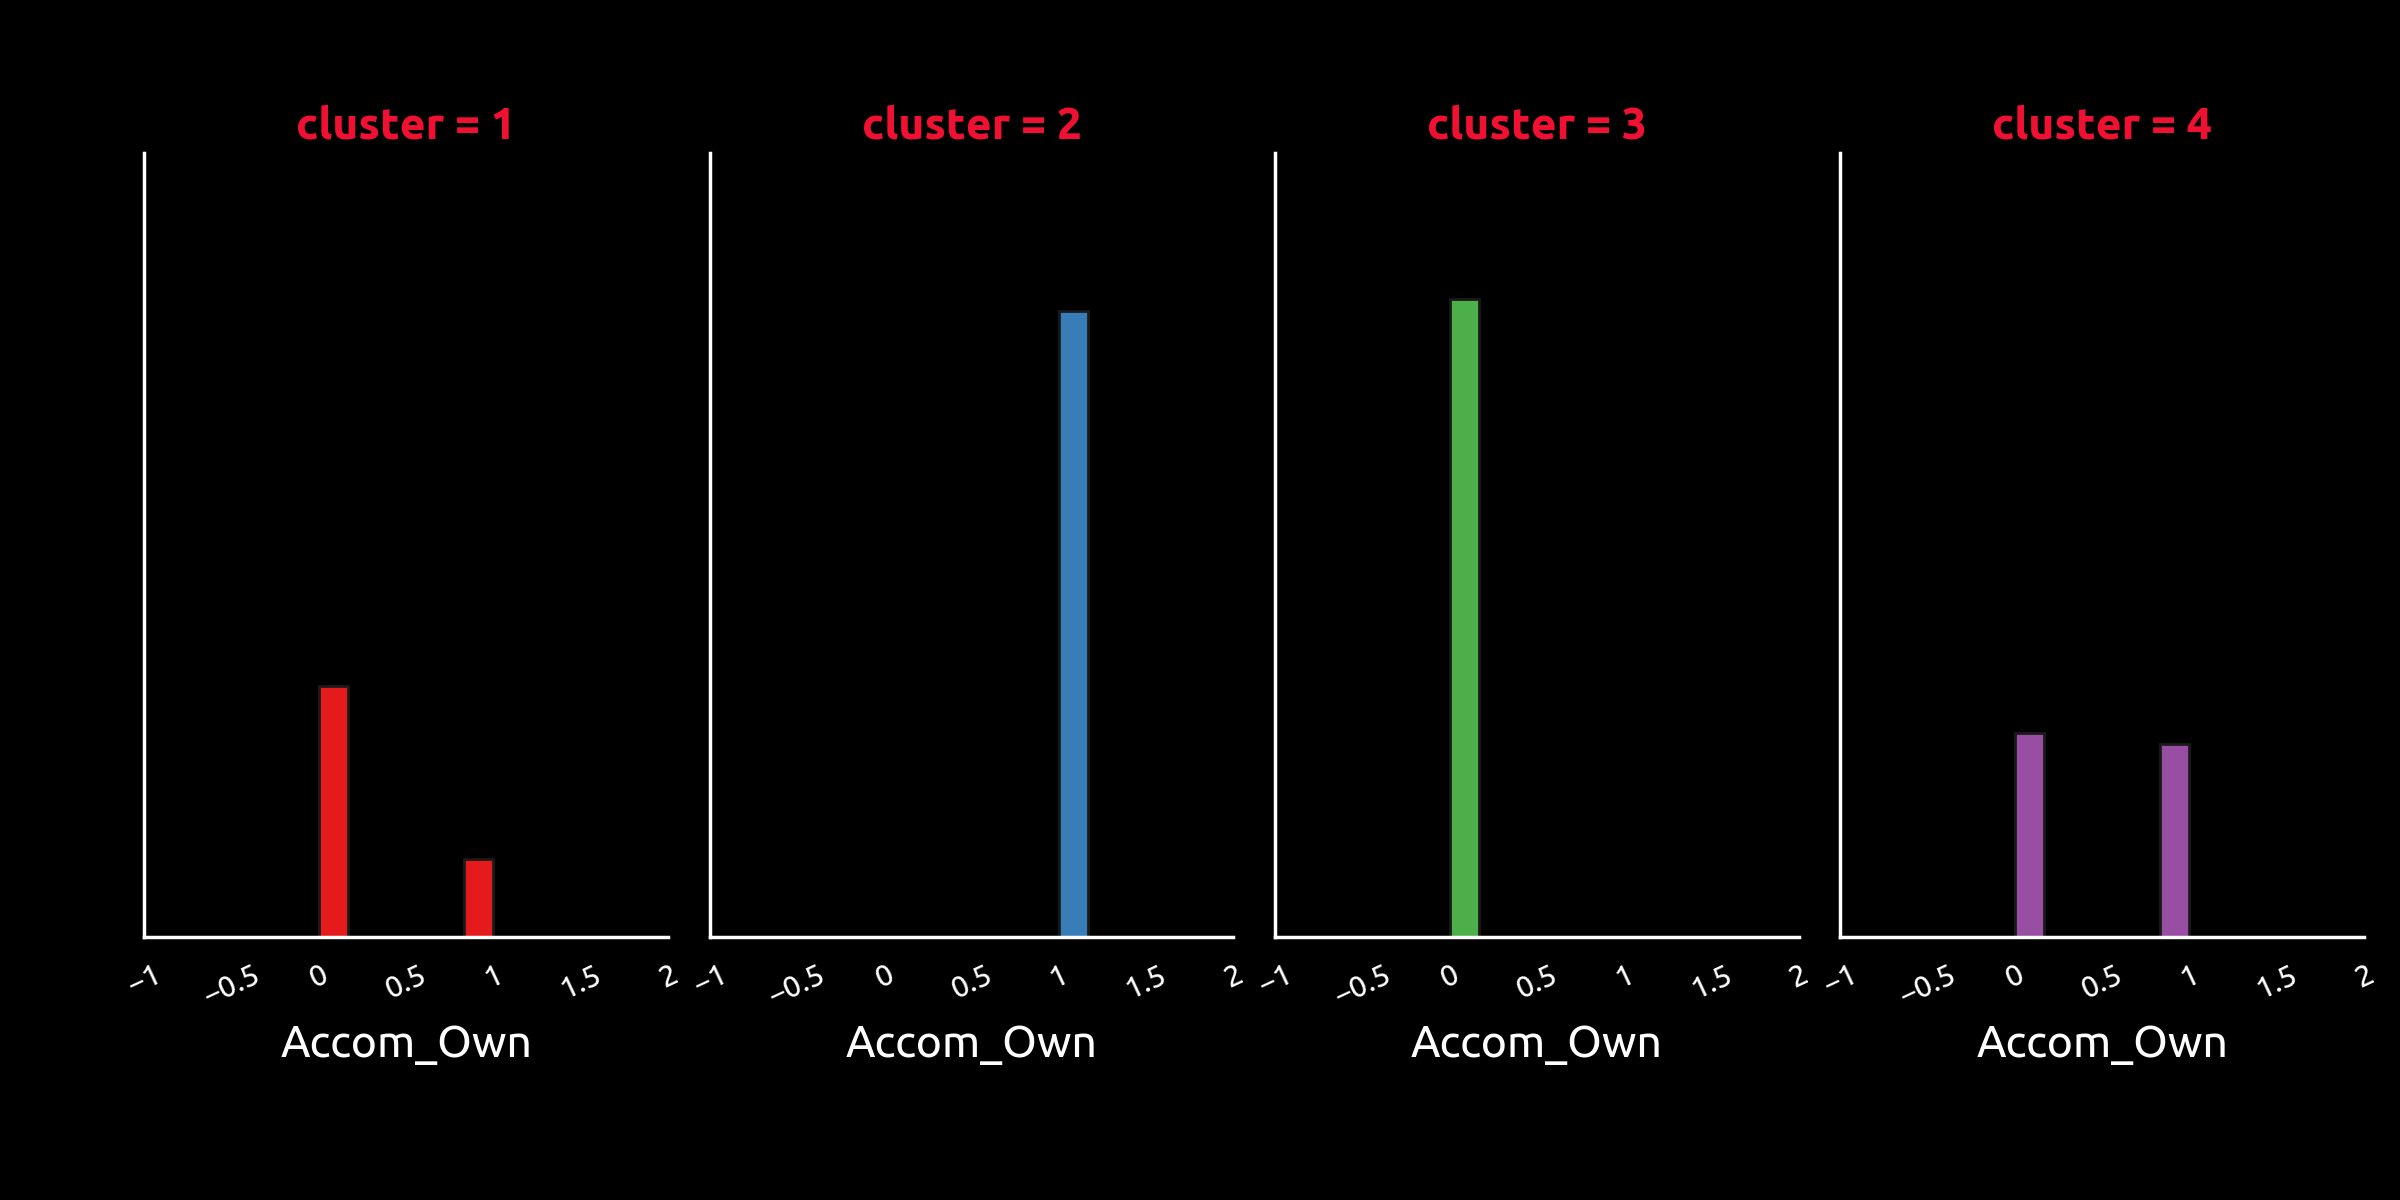

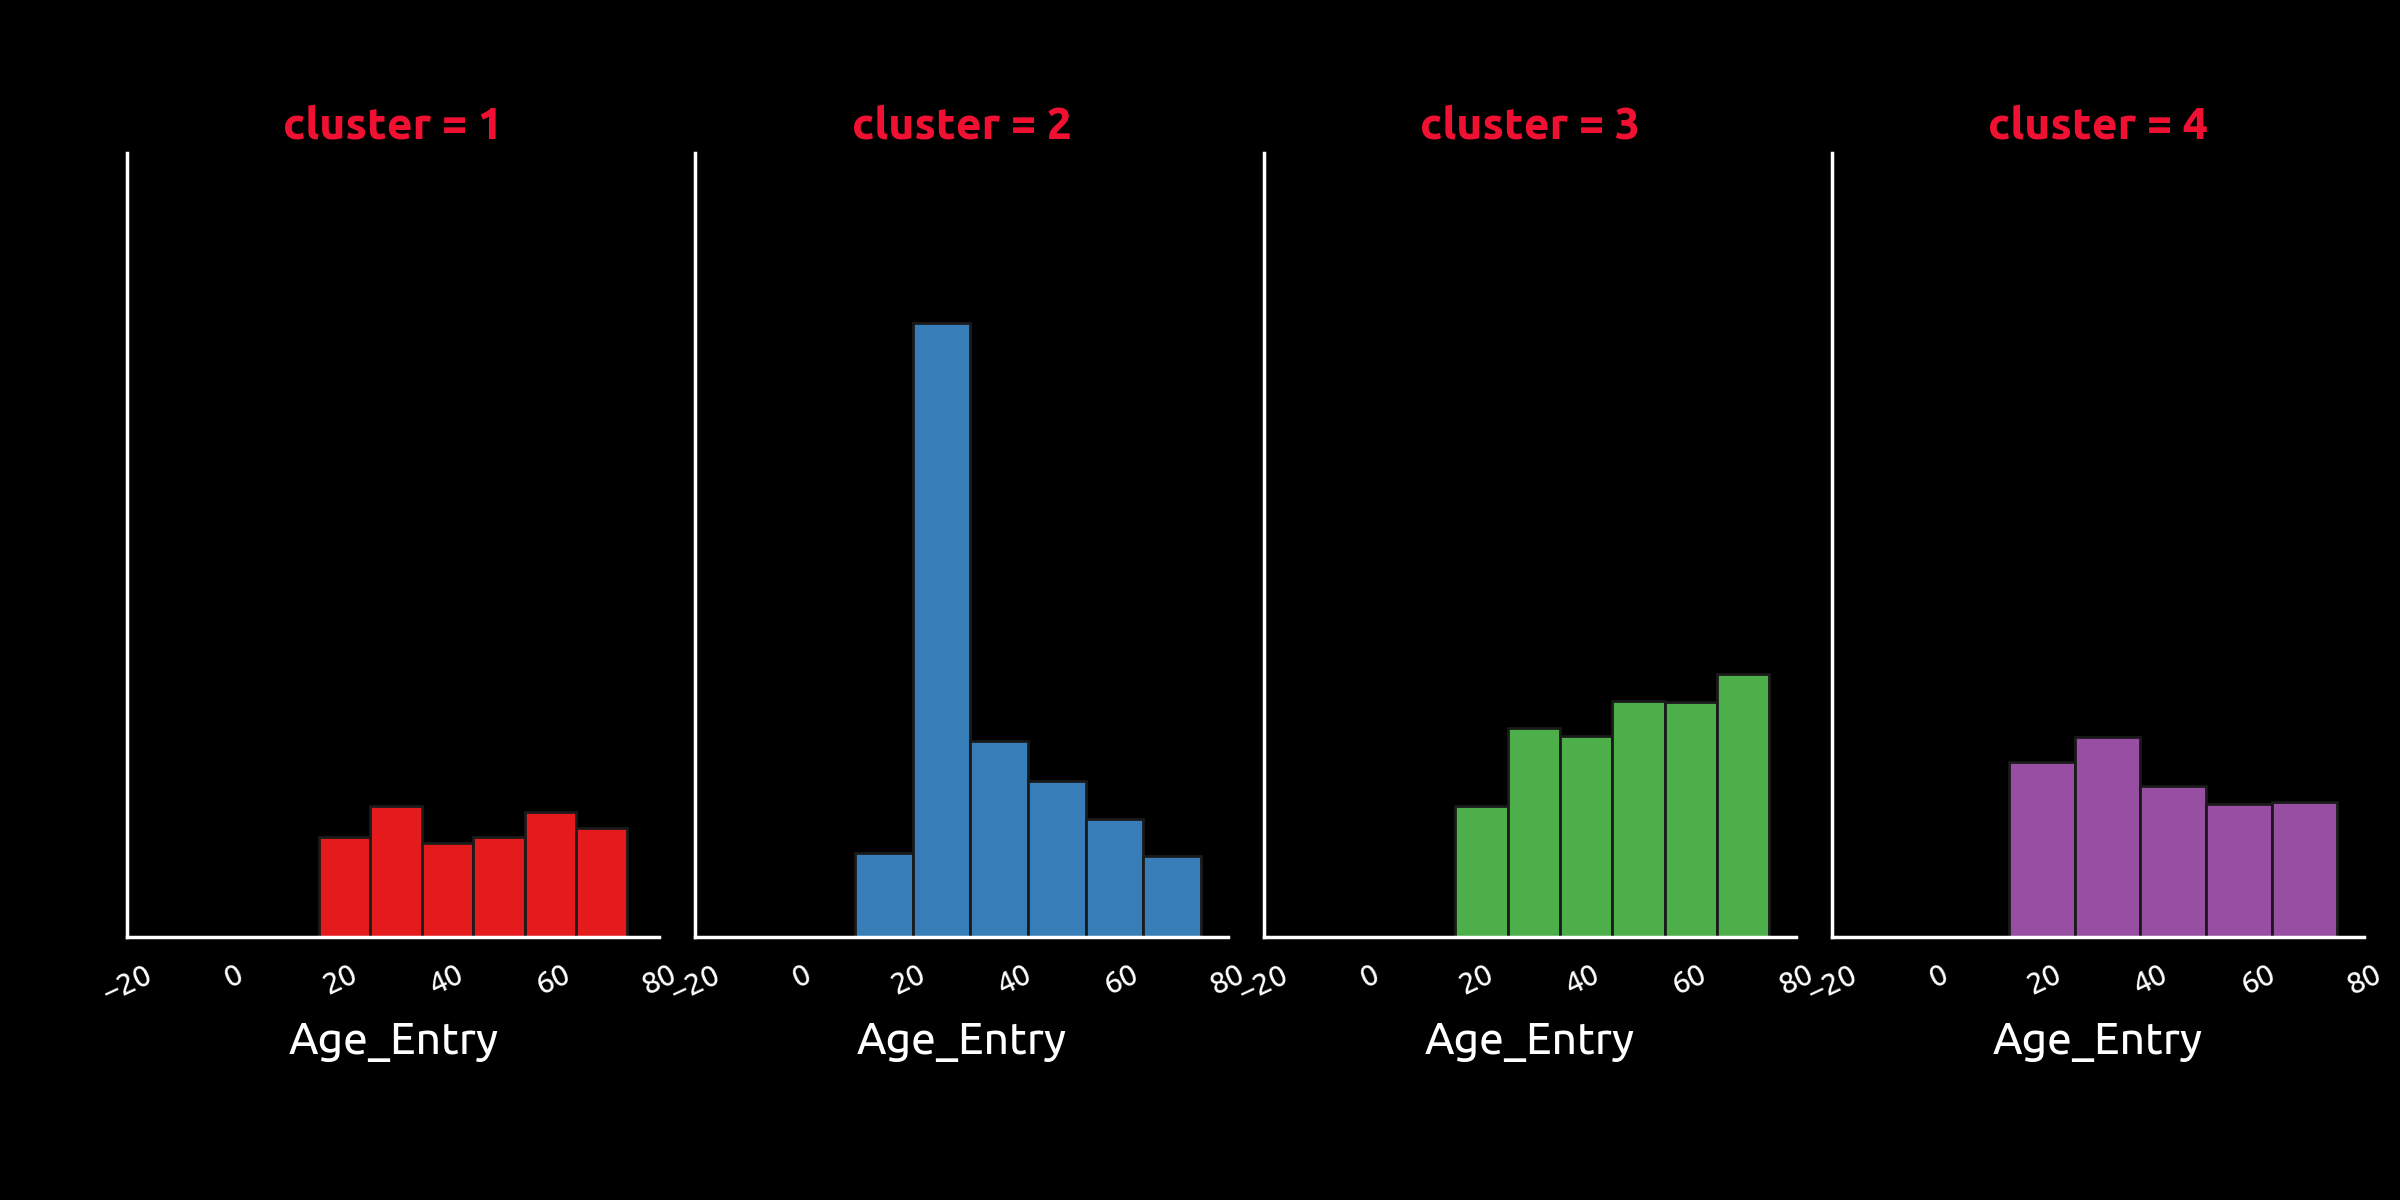

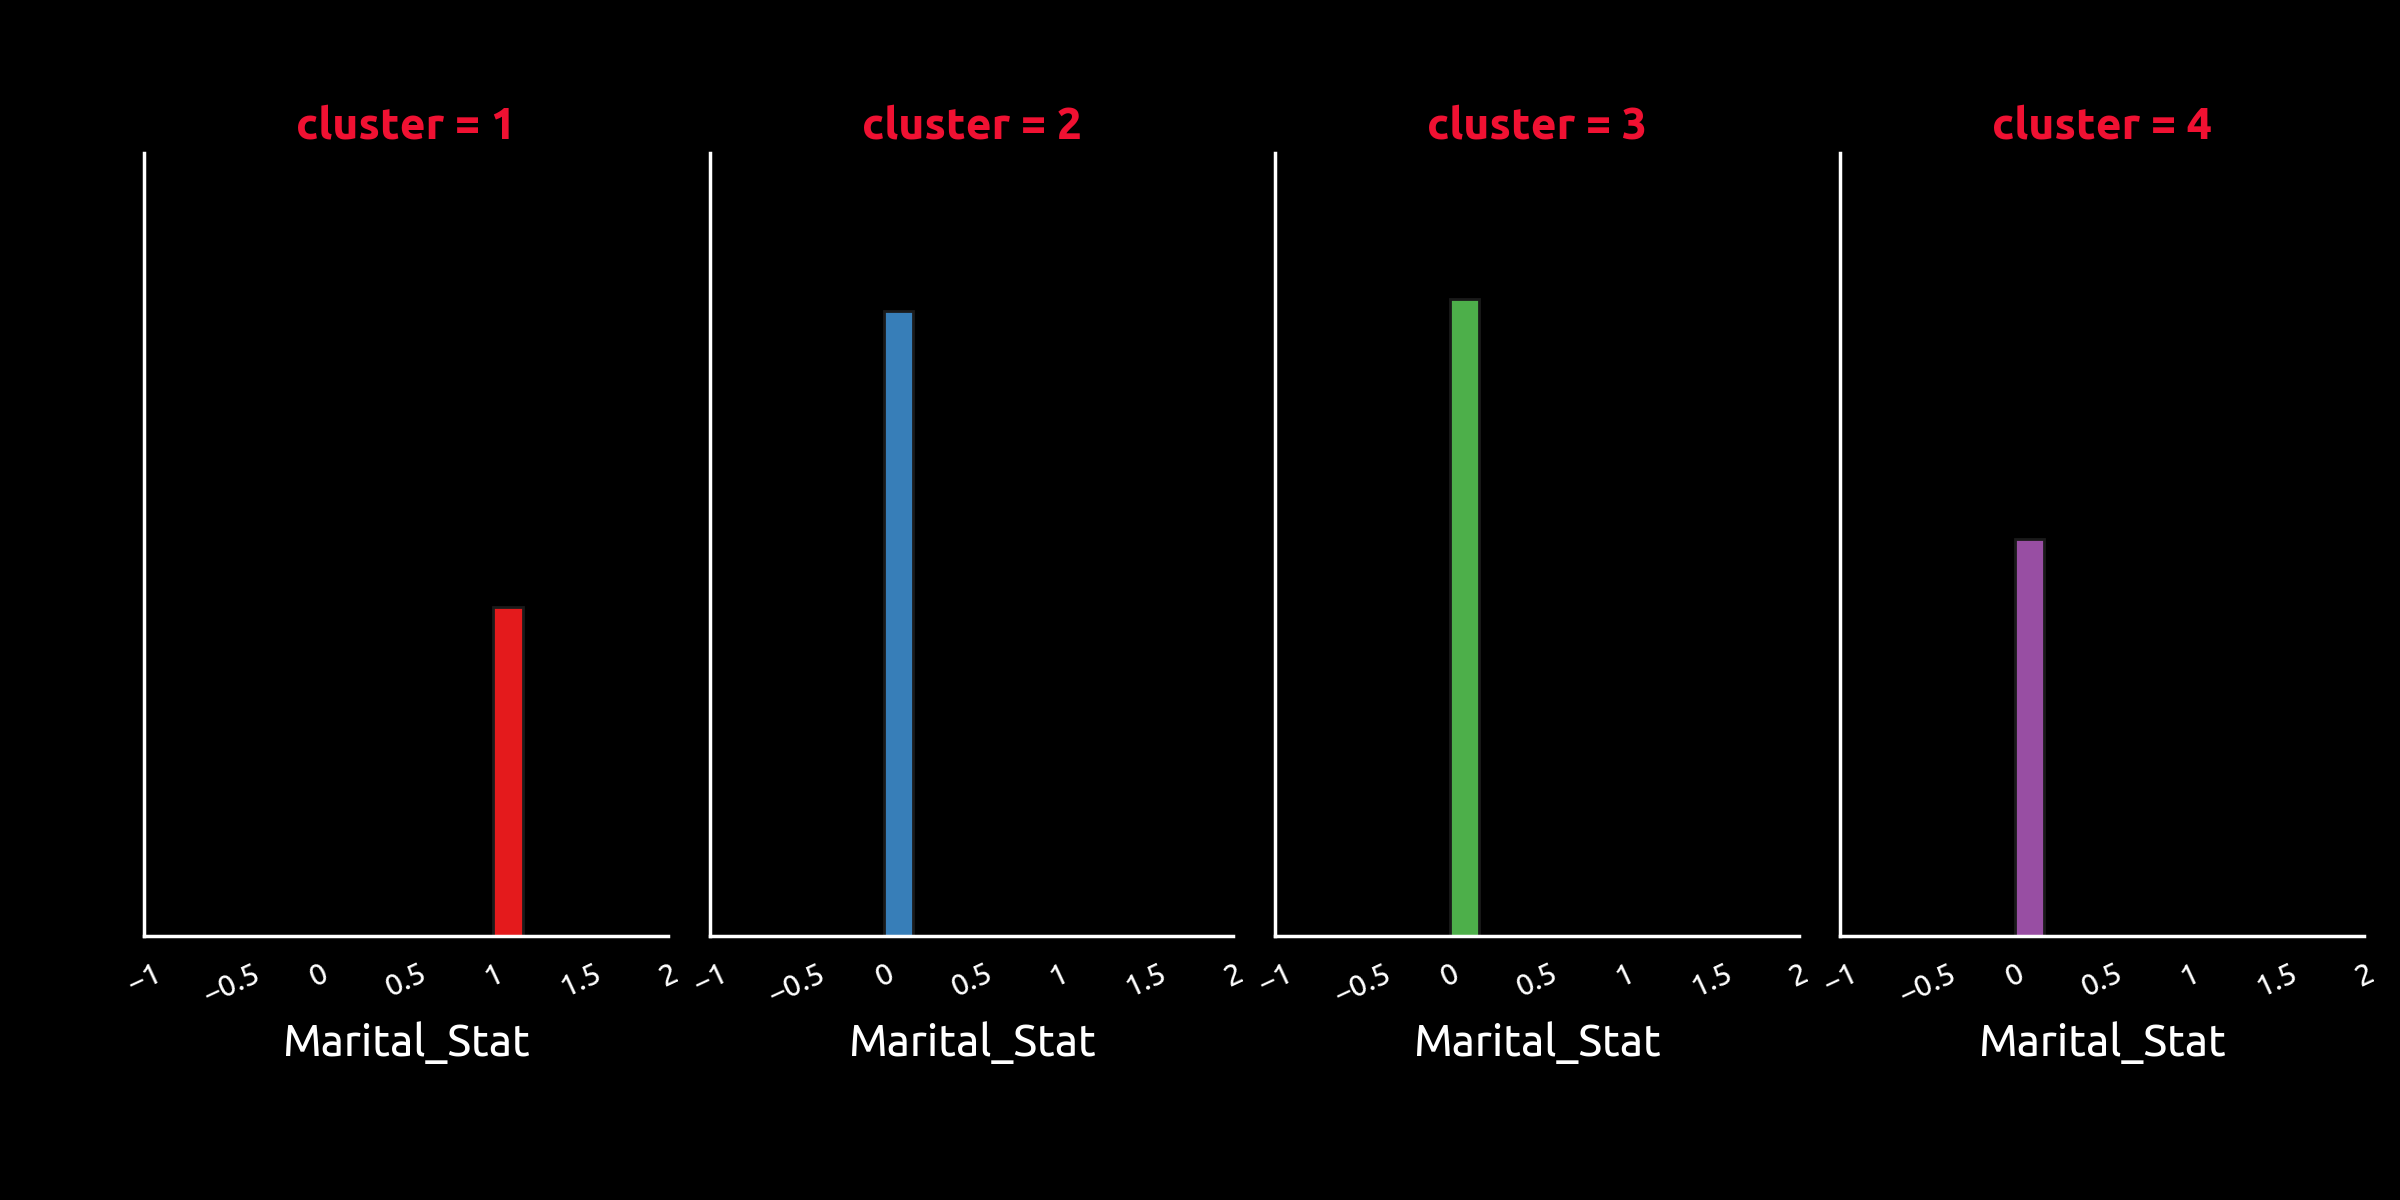

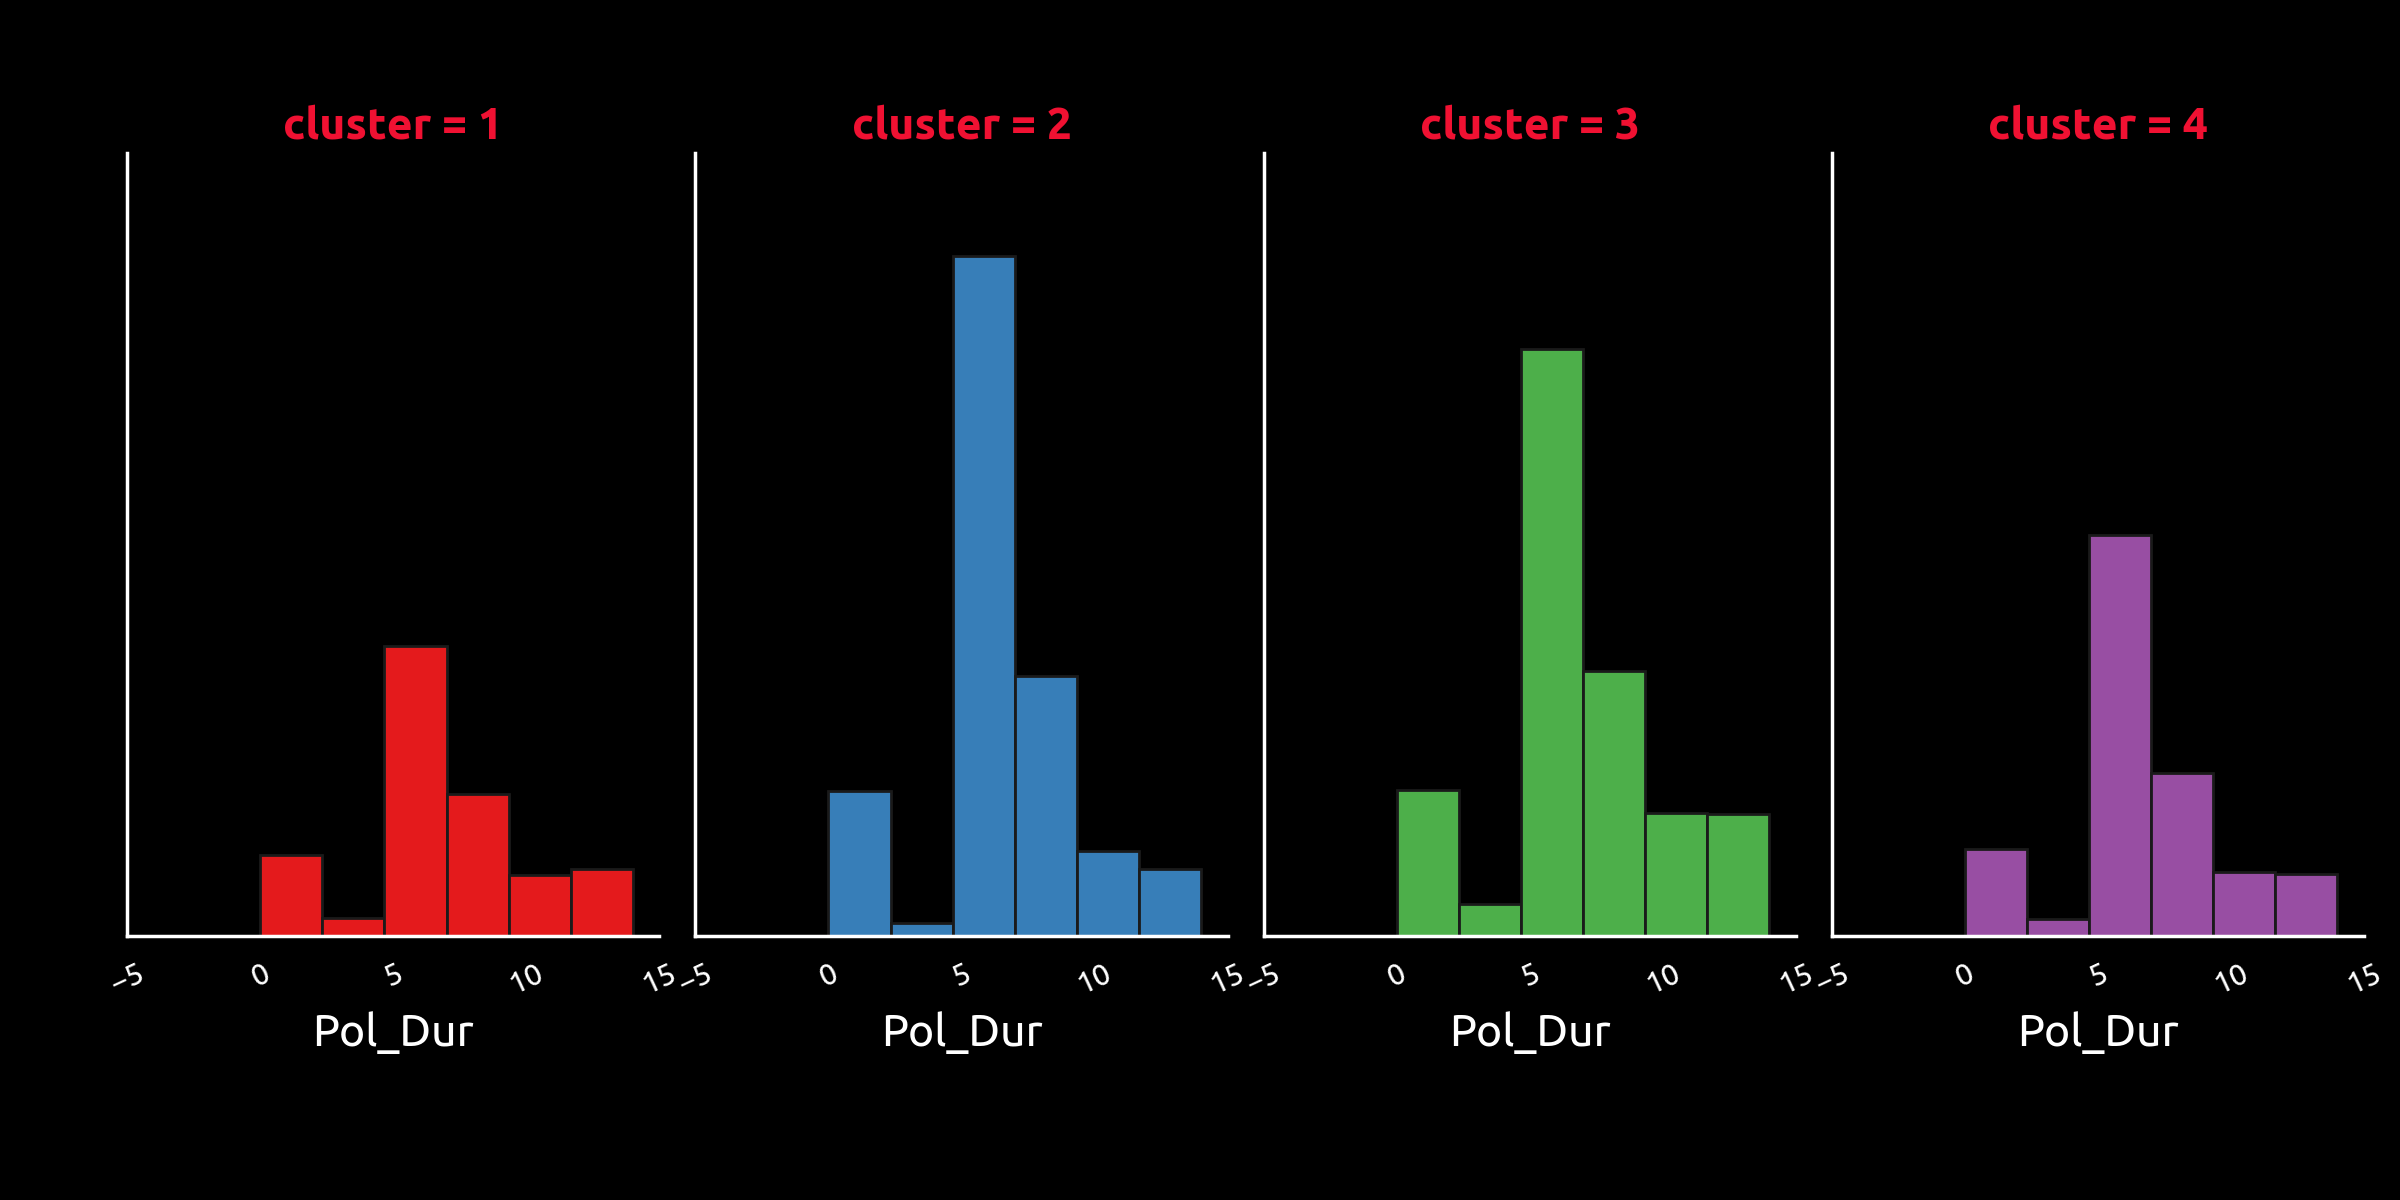

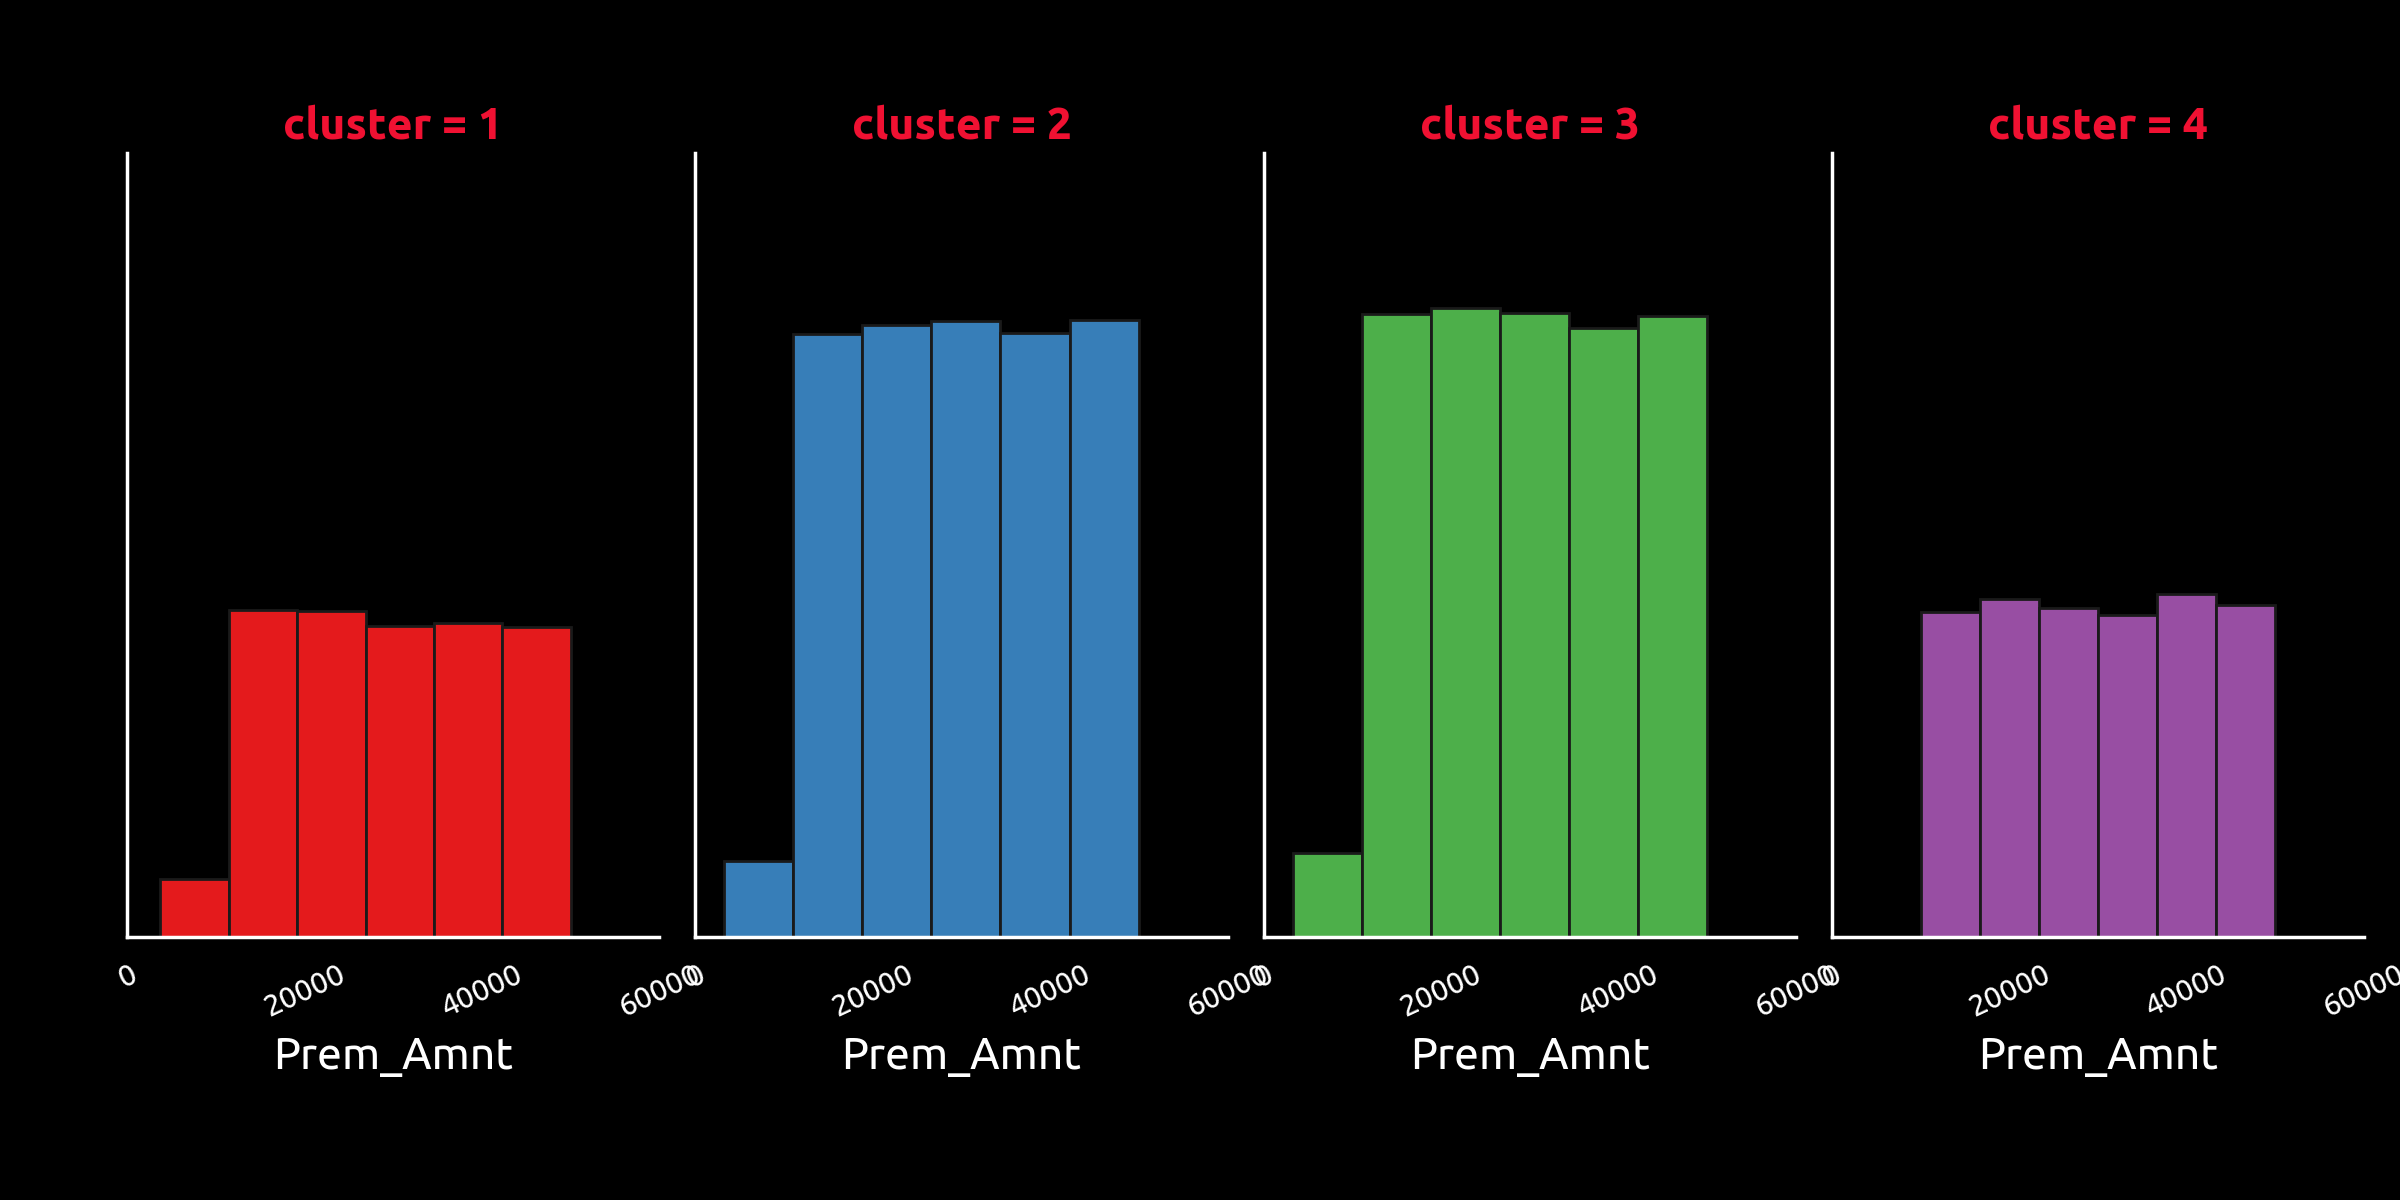

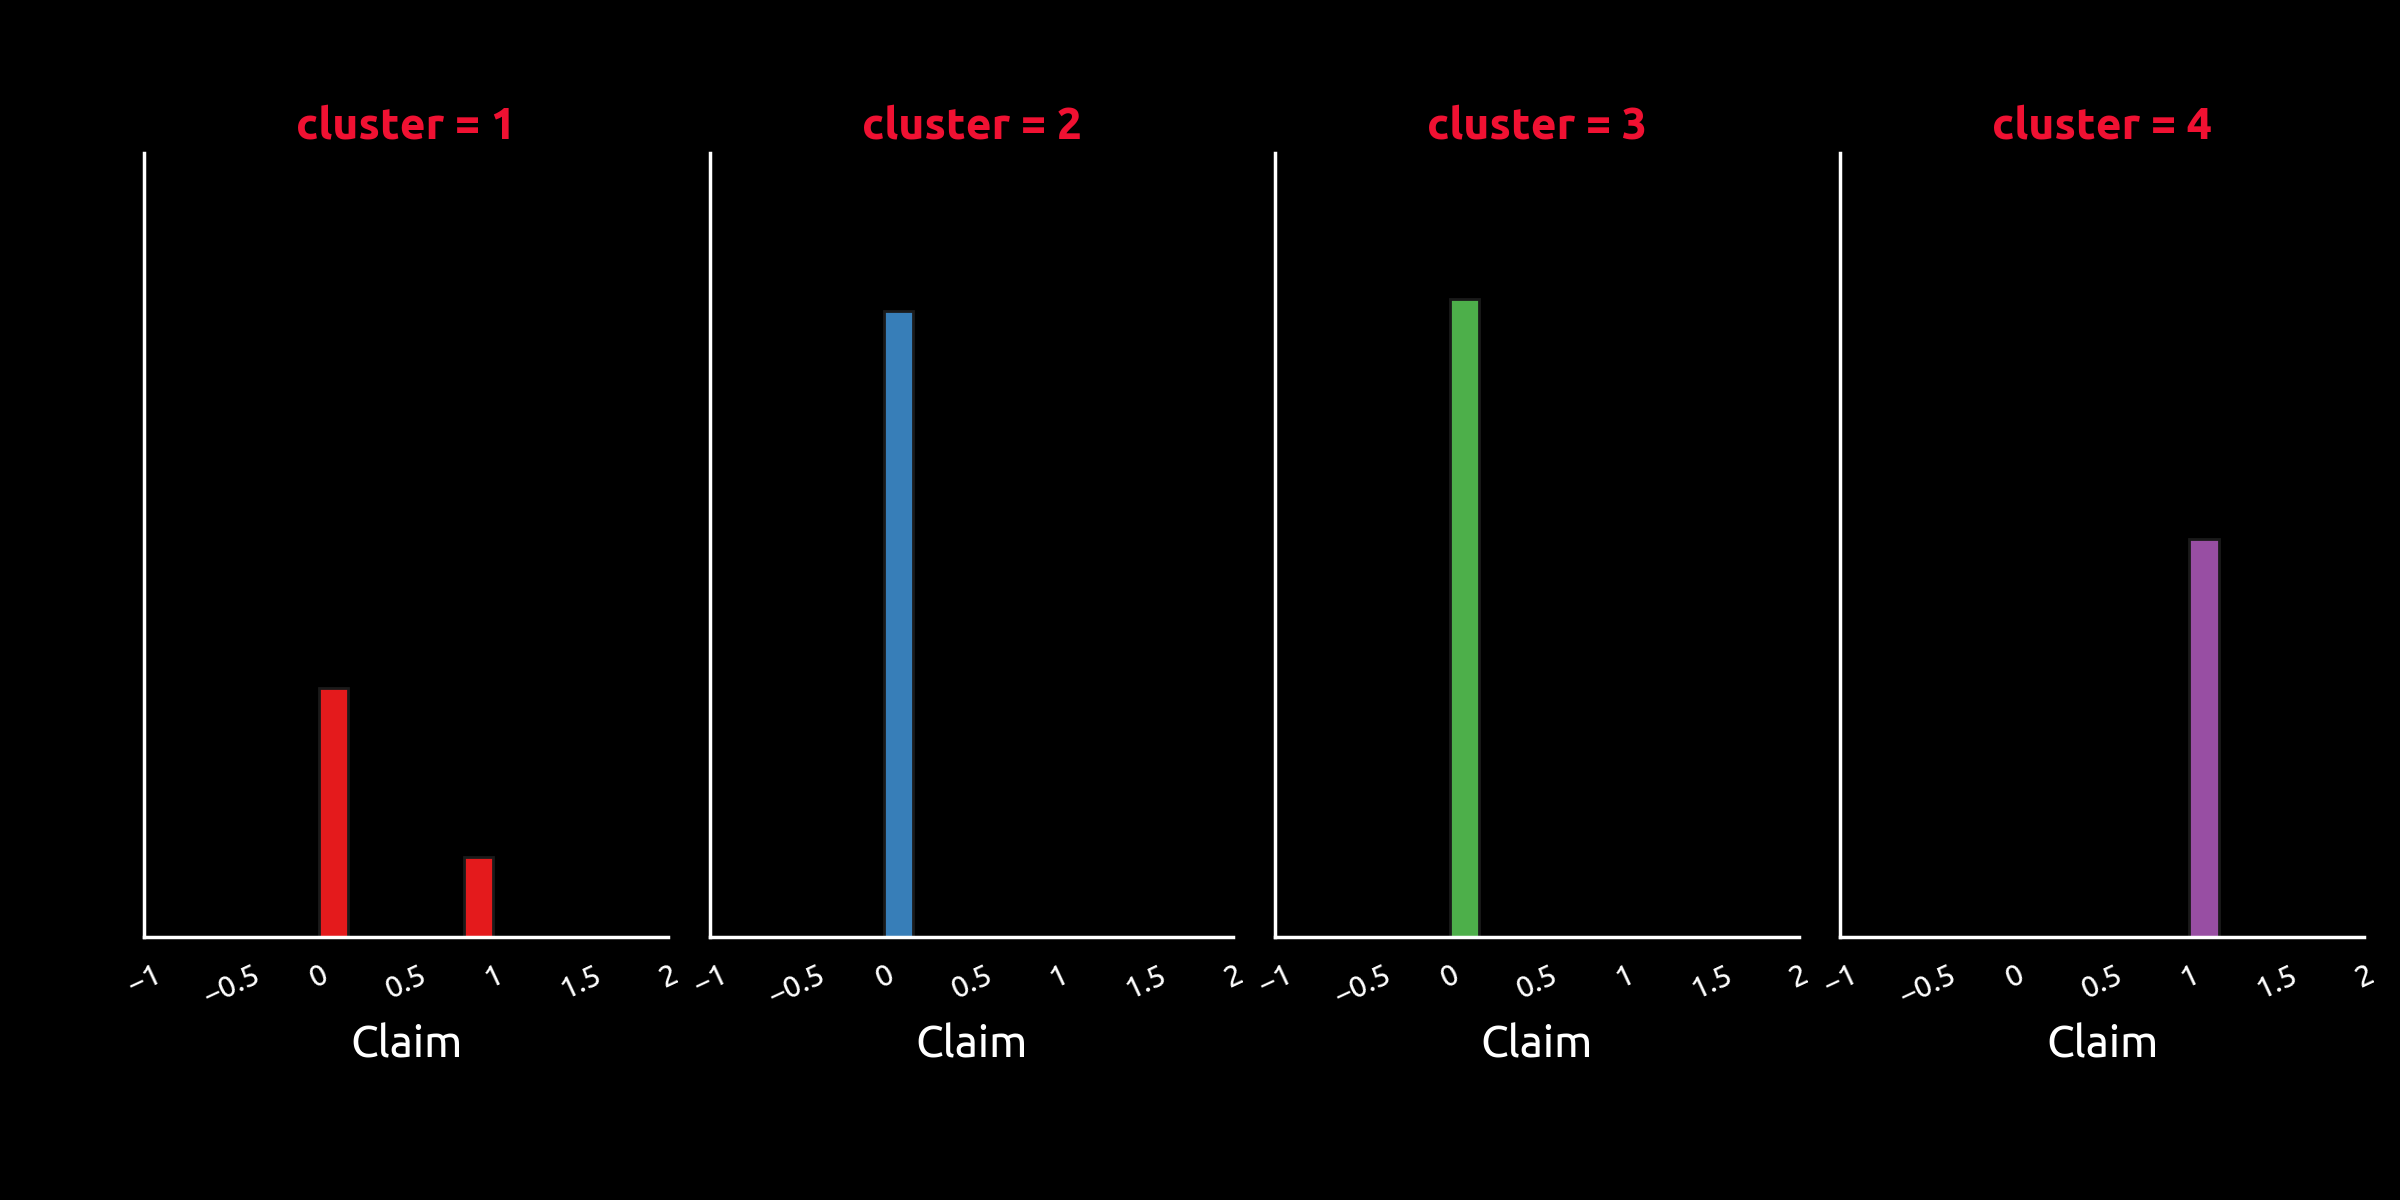

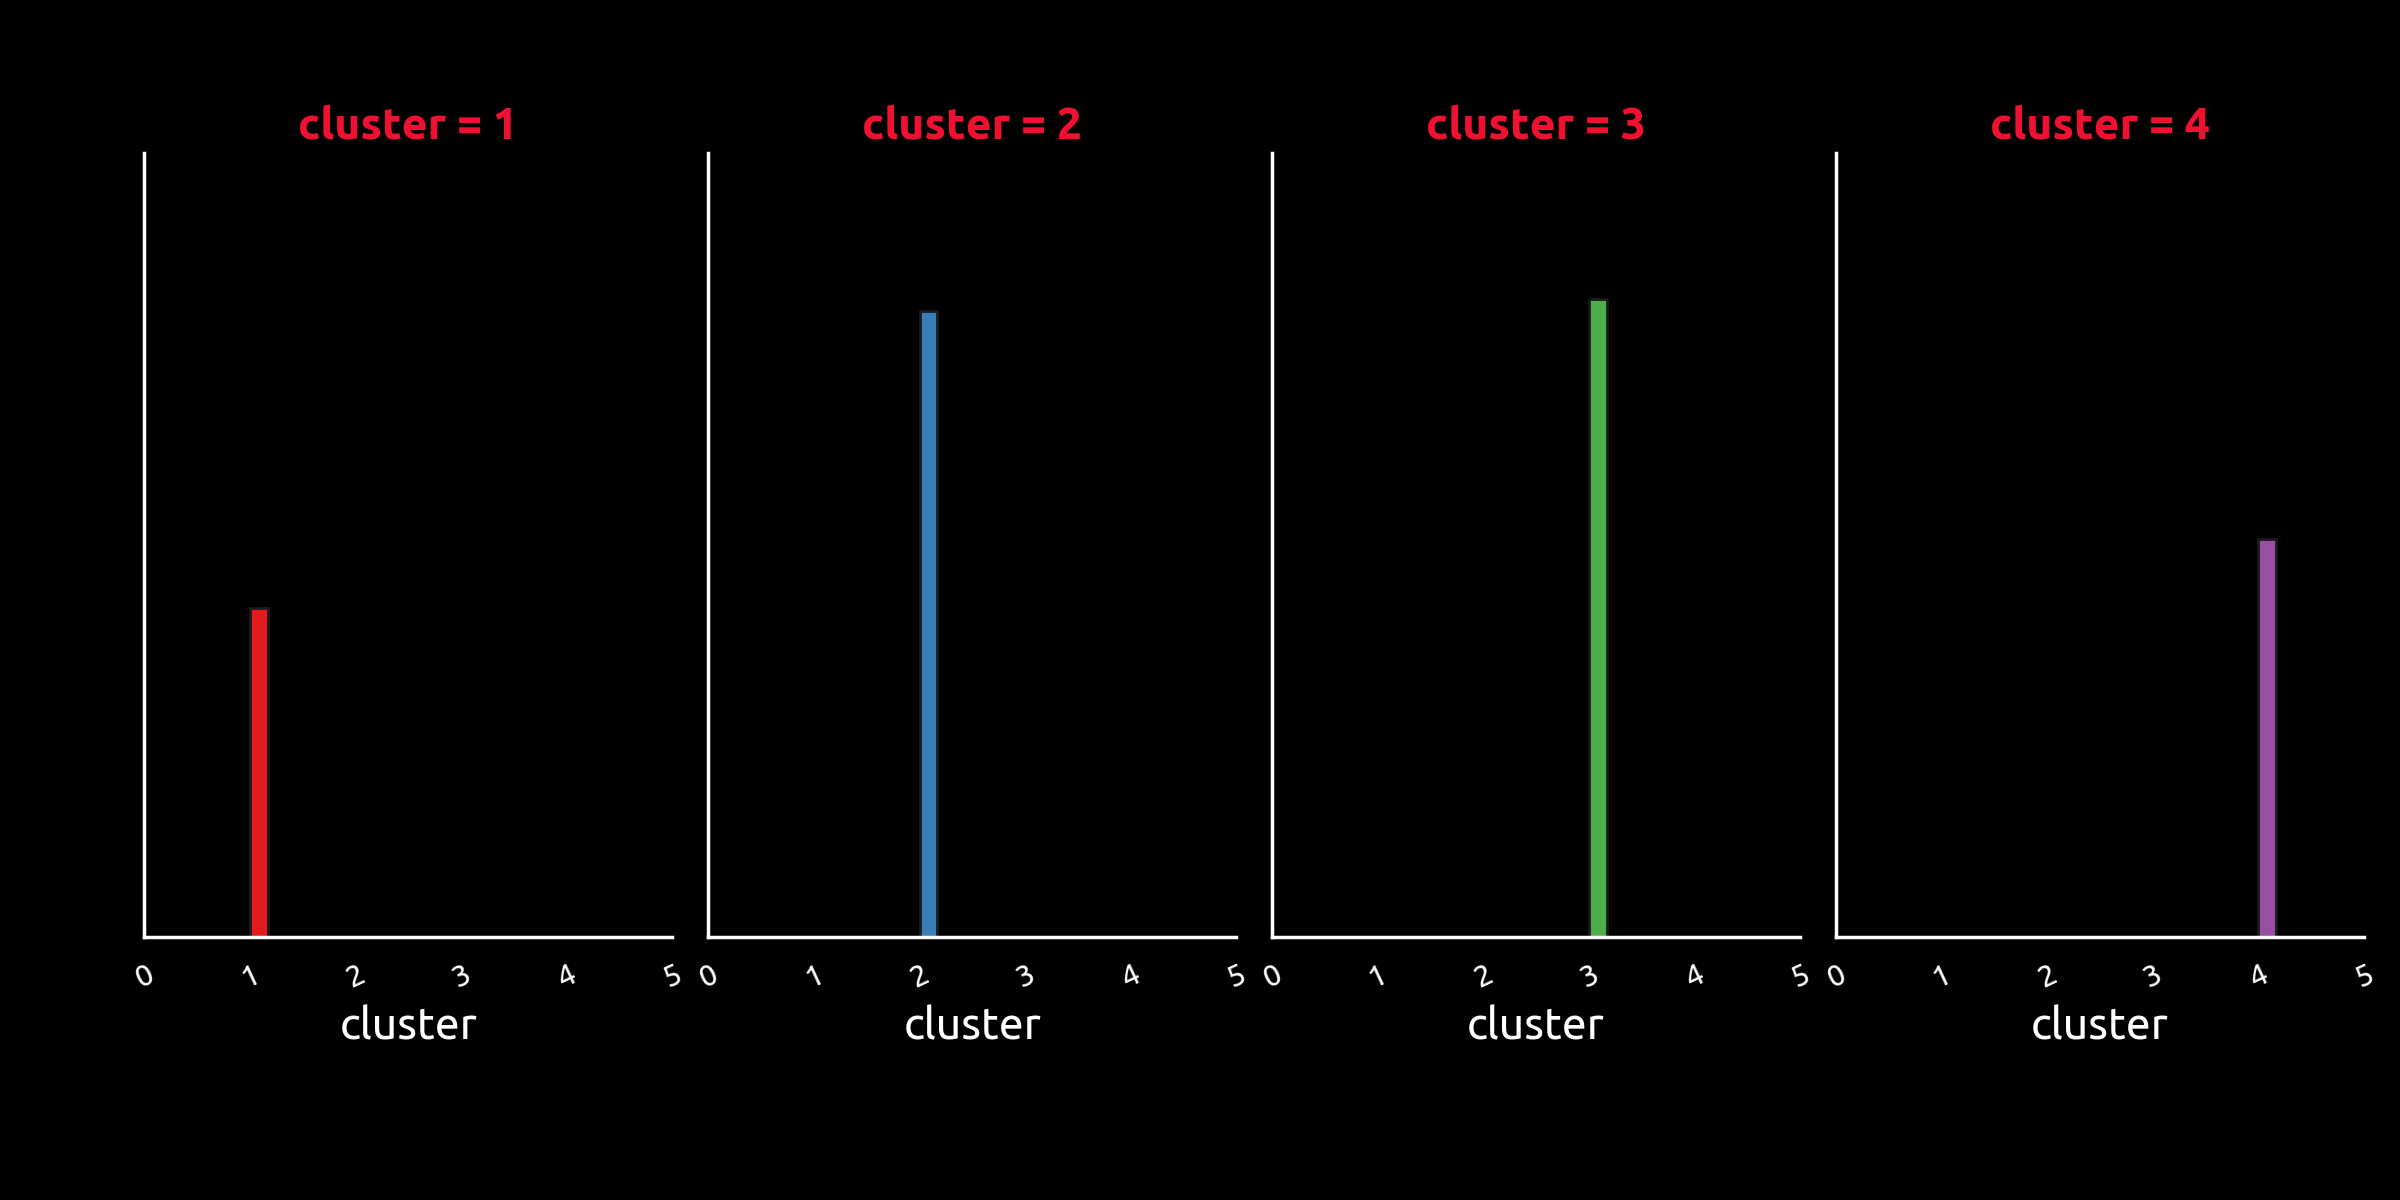

In [38]:




# Clusters interpretation 
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'font.family': 'Ubuntu'})

for i in df1:
    diag = sns.FacetGrid(df1, col = "cluster", hue = "cluster", palette = "Set1")
    diag.map(plt.hist, i, bins=6, ec="k") 
    diag.set_xticklabels(rotation=25, color = 'white')
    diag.set_yticklabels(color = 'white')
    diag.set_xlabels(size=16, color = 'white')
    diag.set_titles(size=16, color = '#f01132', fontweight="bold")
    diag.fig.set_figheight(6)

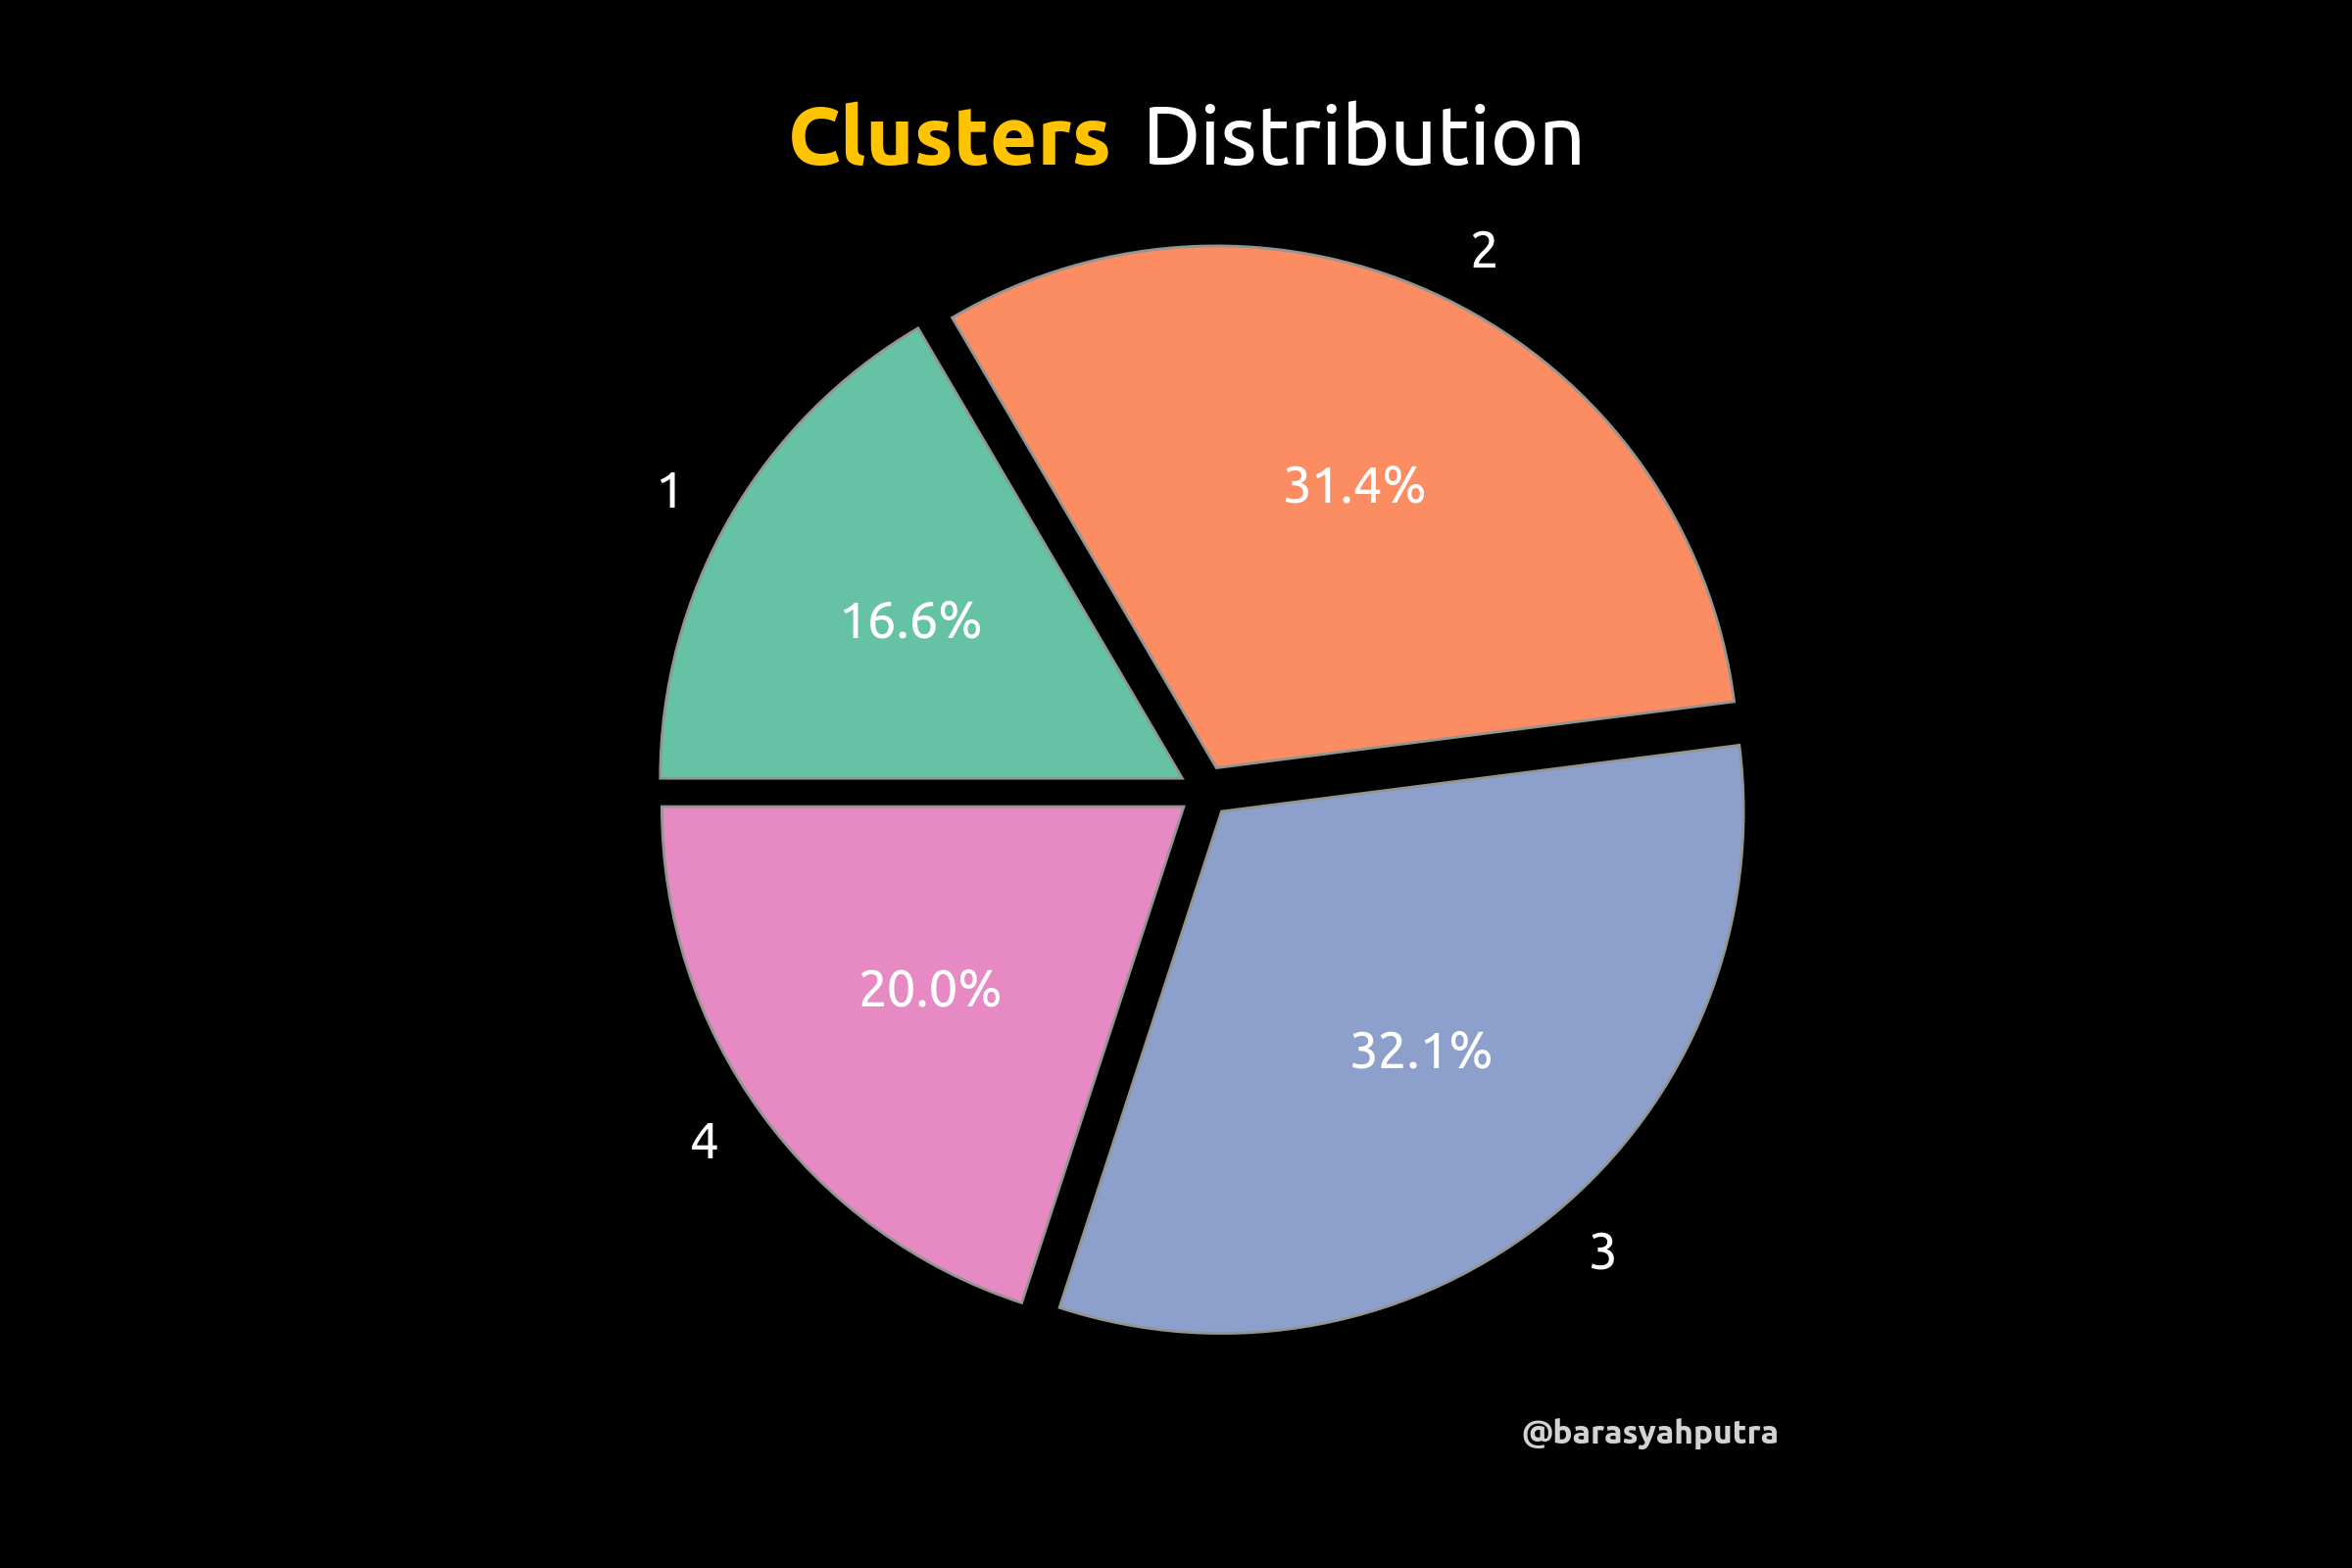

In [39]:
# Results
clusters_count = df1['cluster'].value_counts()                        # Counting wins-losses-draws
clusters_count = clusters_count.to_frame().reset_index()                      # Convert series to dataframe
clusters_count.columns = ['clusters', 'count']                                # Rename column names
clusters_count = clusters_count.sort_values('clusters', ascending = True)     # Sorting data

labels = [
        "1", 
        "2", 
        "3",
        "4"    
        ]

# Visualization
plt.figure(figsize=(12,8))

mpl.rcParams['font.size'] = 17
colors = sns.color_palette('Set2')[0:4]

plt.pie(clusters_count['count'], 
        explode=(0.05, 0.05, 0.05, 0.05), 
        labels = labels,
        colors= colors,
        autopct='%1.1f%%',
        textprops = dict(color ="white", fontsize=19),
        counterclock = False,
        startangle=180,
        wedgeprops={"edgecolor":"gray",'linewidth': 1}
        )

plt.axis('equal')

# Title 
plt.text(-0.8, 1.2, "Clusters", size=30, color="#FFC300", fontweight="bold")
plt.text(-0.12, 1.2, "Distribution", size=30, color="white")

# Author
plt.text(1.1, -1.25, "@barasyahputra", fontsize=12, ha="right", color='lightgray', fontweight="bold")

plt.show()


### REPORT

#### Based on above information we can divide customer into 3 parts:- 

1. **Least Active Customer**     :- These customers belong to cluster one.
2. **Moderately Active Customer** :- These customers belong to cluster two.
3. **Highly Active Customer**      :-  These customers belong to cluster third.

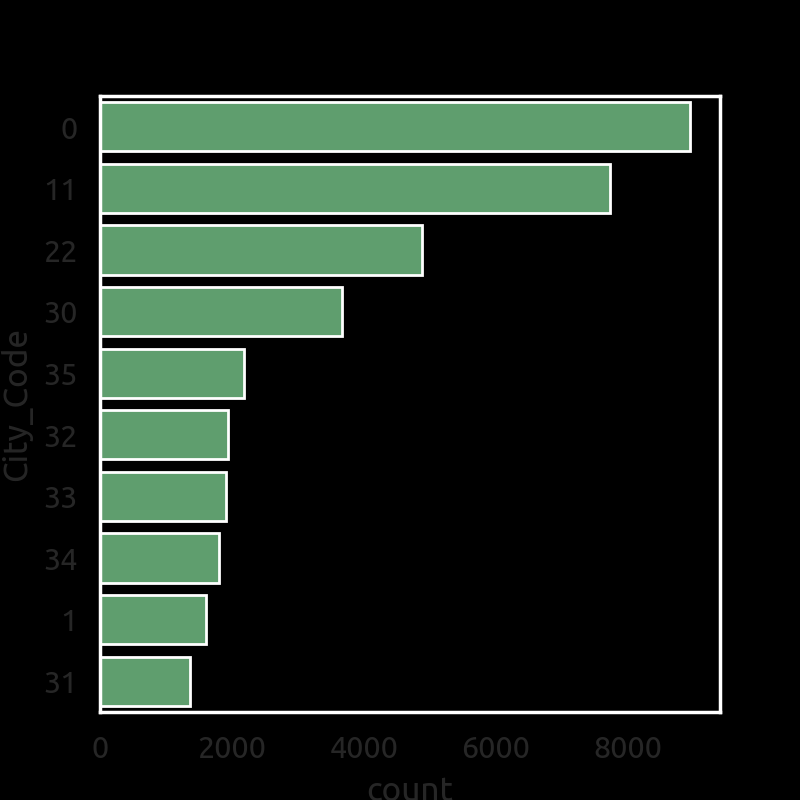

In [40]:
base_color = sns.color_palette()[2]

sns.countplot(y = 'City_Code',color= base_color, data = df1, order = df1
              
              
              .City_Code.value_counts().head(10).index)

plt.title("Top 10 City Code", fontsize = 20);